**1.0 PREPARE ENVIRONMENT**

**1.1  Install and Import Necessary Packages and Libraries**

In [67]:
# Install the following necessary packages
!pip install numpy pandas geopandas matplotlib rasterio scipy shapely scikit-learn dask[distributed] dask_geopandas fiona pyogrio colorcet osmnx adjustText contextily matplotlib-scalebar libpysal


# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D

import colorcet as cc

import colorsys
from collections import defaultdict

import contextily as ctx

import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.features import shapes
from rasterio.plot import show

import os

from scipy.ndimage import generic_filter
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist


from shapely.geometry import shape, mapping
from shapely.geometry import Polygon
from shapely.ops import unary_union

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from libpysal.weights import DistanceBand

import dask.array as da
import dask_geopandas as dg
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar

import fiona

from adjustText import adjust_text


**1.2  Load all Input Images - Landscape Elements**

To see how each input dataset was derived, kindly see the GEE_data_acq.ipnyb notebook which is located at: _f'../notebooks/GEE_Dataset._

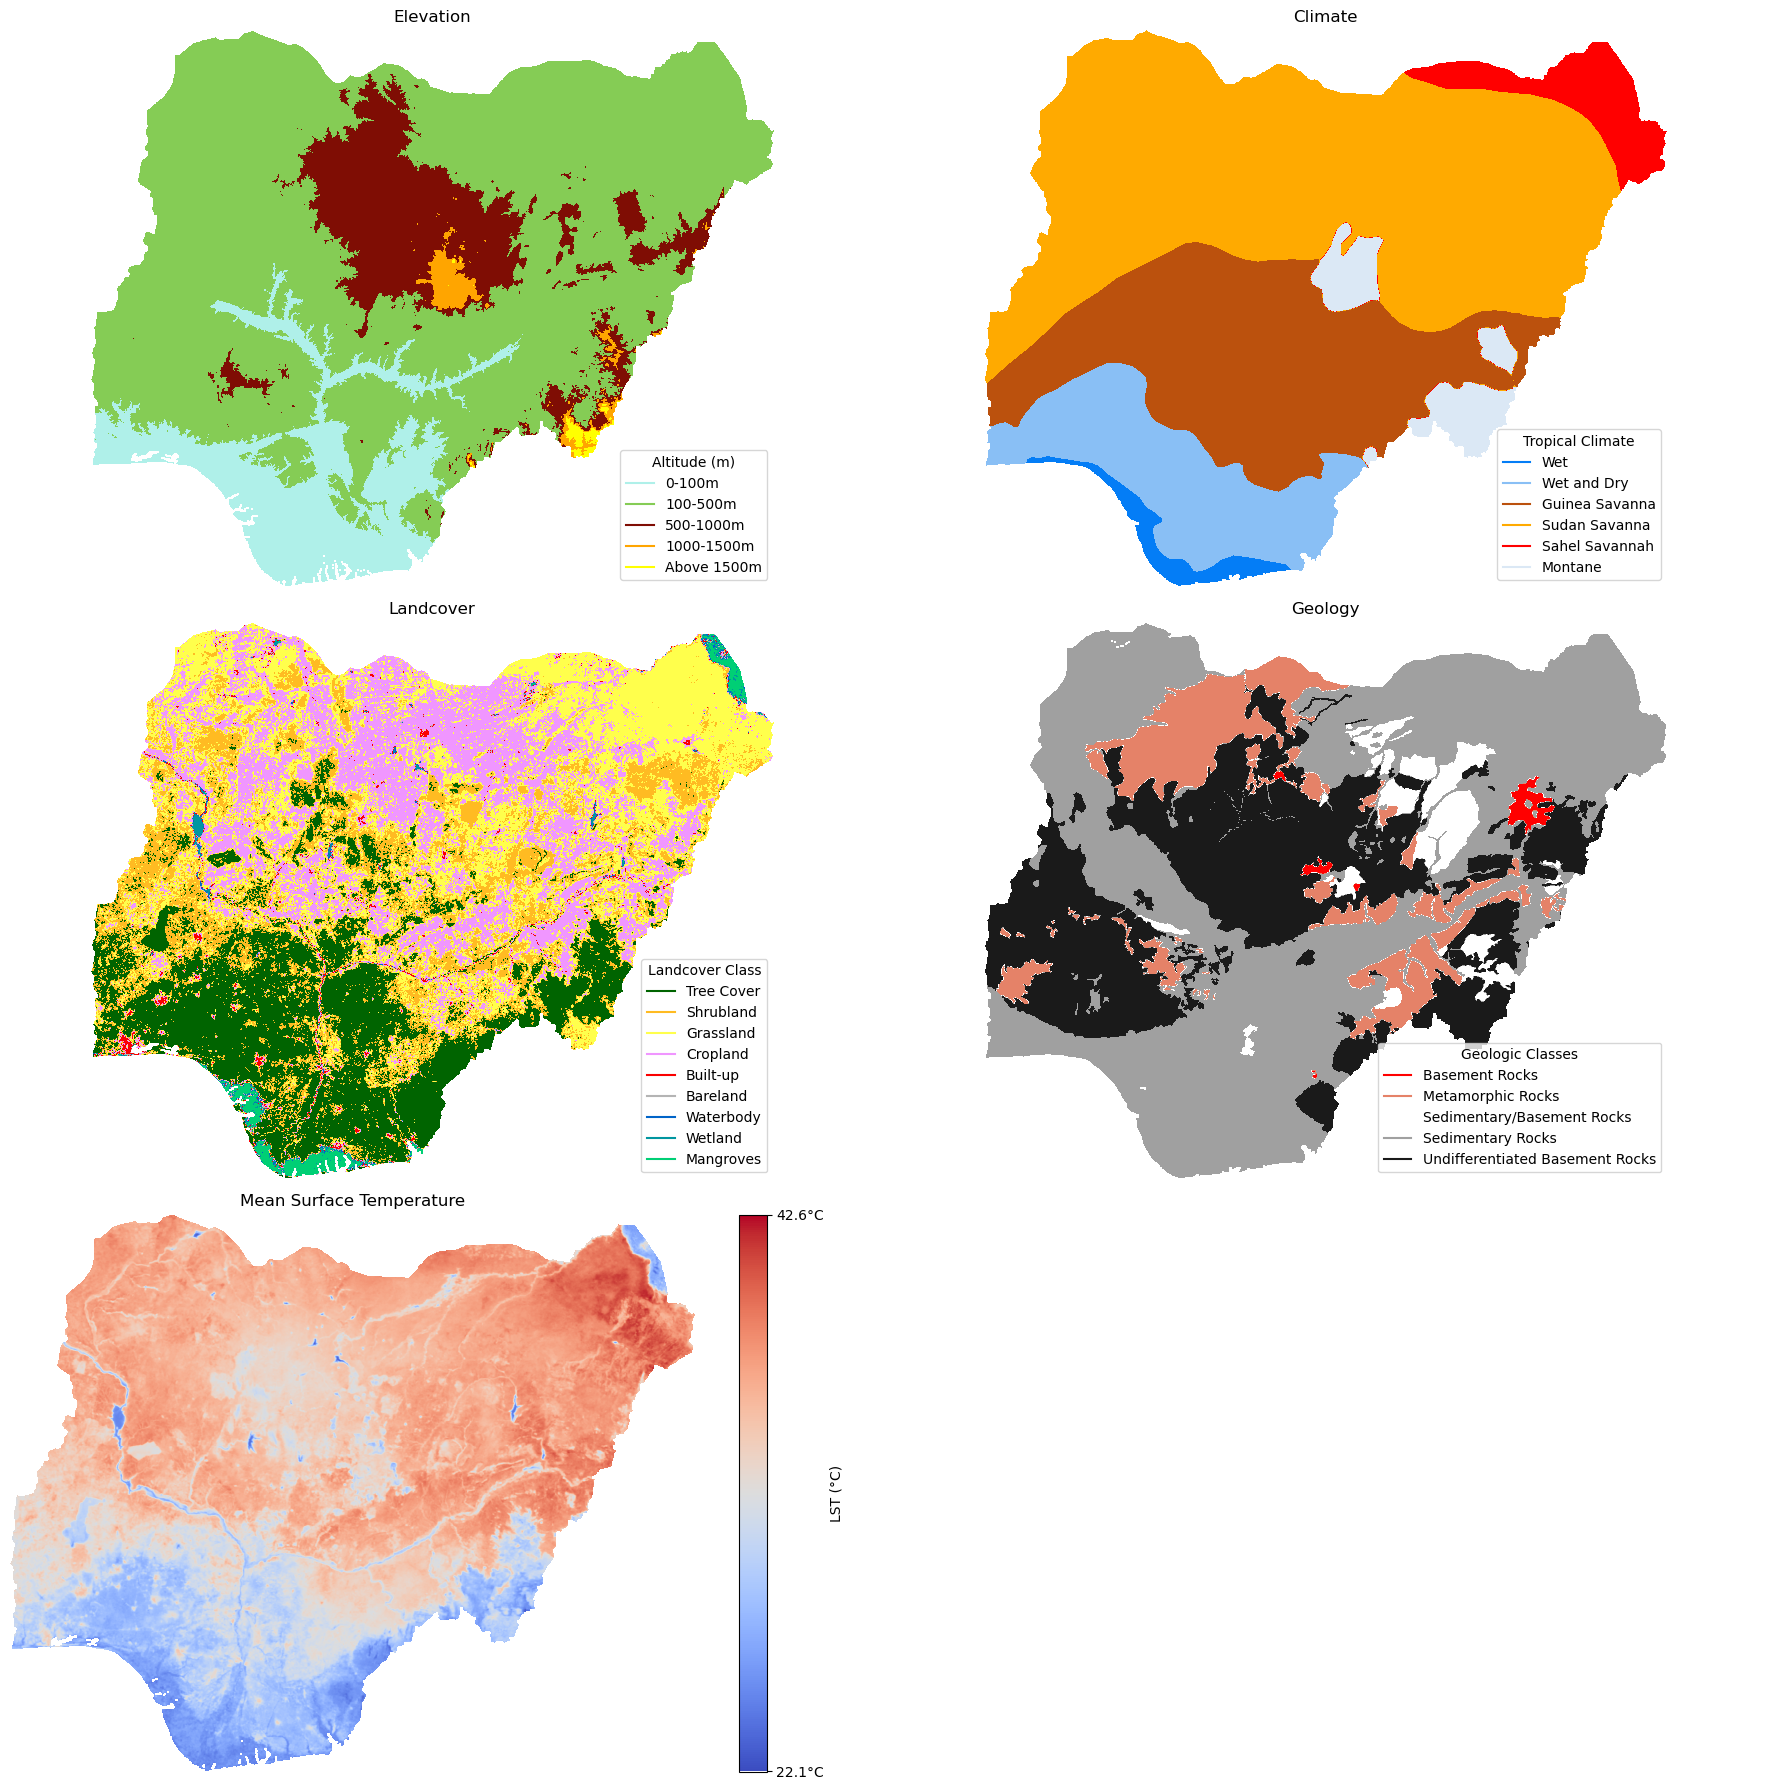

In [68]:
# Load classified images
landcover_path = 'all_input_dataset/Nigeria_Landcover_2021.tif'
elevation_path = 'all_input_dataset/Classified_Altitude_Nigeria.tif'
climate_path = 'all_input_dataset/Nig_climate.tif'
geology_path = 'all_input_dataset/Nig_geology.tif'
lst_path = 'all_input_dataset/Mean_LST_Nigeria.tif' # not used for computation...

# Load images
with rasterio.open(landcover_path) as src:
    landcover = src.read(1)
    landcover_masked = np.ma.masked_equal(landcover, 0)  # Mask NoData (value 0)

with rasterio.open(elevation_path) as src:
    elevation = src.read(1)
    # Ensure the masking of the elevation data
    elevation_masked = np.ma.masked_equal(elevation, 0)  # Mask NoData (value 0)
    elevation_masked = np.ma.masked_equal(elevation_masked, -32768)  # Mask NoData (-32768)

with rasterio.open(climate_path) as src:
    climate = src.read(1)
    climate_masked = np.ma.masked_equal(climate, 0)  # Mask NoData (value 0)
    
with rasterio.open(geology_path) as src:
    geology = src.read(1)
    geology_masked = np.ma.masked_equal(geology, 0)  # Mask NoData (value 0)
    
with rasterio.open(lst_path) as src:
    lst = src.read(1)
    lst_masked = np.ma.masked_invalid(lst)  # Mask invalid values (NaN and infinite)

# Define color maps and legends for each image
landcover_cmap = ListedColormap(['#006400', '#ffbb22', '#ffff4c', '#f096ff', '#fa0000', '#b4b4b4', '#0064c8', '#0096a0', '#00cf75'])
elevation_cmap = ListedColormap(['#AFF0E9', '#85CC55', '#7F0D04', 'orange', 'yellow'])  # Adjust color map to match the elevation classes
climate_cmap = ListedColormap(['#047df6', '#89bff5', '#BB510D', '#FFAA00', 'red', '#dbe8f5'])
geology_cmap = ListedColormap(['#FF0000', '#E58268', '#FFFFFF', '#A0A0A0', '#1A1A1A'])
lst_cmap = plt.cm.coolwarm  # Using a predefined colormap for continuous data

landcover_legend_labels = ['Tree Cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bareland', 'Waterbody', 'Wetland', 'Mangroves']
elevation_legend_labels = ['0-100m', '100-500m', '500-1000m', '1000-1500m', 'Above 1500m']
climate_legend_labels = ['Wet', 'Wet and Dry', 'Guinea Savanna', 'Sudan Savanna', 'Sahel Savannah', 'Montane']
geology_legend_labels = ['Basement Rocks', 'Metamorphic Rocks', 'Sedimentary/Basement Rocks', 'Sedimentary Rocks', 'Undifferentiated Basement Rocks']

# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(18, 18))

# Plot elevation
elevation_img = axs[0, 0].imshow(elevation_masked, cmap=elevation_cmap)
axs[0, 0].set_title('Elevation')
axs[0, 0].axis('off')

# Create a list of patches for the elevation legend
elevation_patches = [plt.plot([], [], color=color, label=label)[0] for color, label in zip(elevation_cmap.colors, elevation_legend_labels)]

# Create the elevation legend
elevation_legend = axs[0, 0].legend(title='Altitude (m)', handles=elevation_patches, loc='lower right')

# Plot Climate
climate_img = axs[0, 1].imshow(climate_masked, cmap=climate_cmap)
axs[0, 1].set_title('Climate')
axs[0, 1].axis('off')

# Create a list of patches for the Climate legend
climate_patches = [plt.plot([], [], color=color, label=label)[0] for color, label in zip(climate_cmap.colors, climate_legend_labels)]

# Create the Climate legend
climate_legend = axs[0, 1].legend(title='Tropical Climate', handles=climate_patches, loc='lower right')

# Plot Geology
geology_img = axs[1, 1].imshow(geology_masked, cmap=geology_cmap)
axs[1, 1].set_title('Geology')
axs[1, 1].axis('off')

# Create a list of patches for the Geology legend
geology_patches = [plt.plot([], [], color=color, label=label)[0] for color, label in zip(geology_cmap.colors, geology_legend_labels)]

# Create the Geology legend
geology_legend = axs[1, 1].legend(title='Geologic Classes', handles=geology_patches, loc='lower right')

# Plot landcover
landcover_img = axs[1, 0].imshow(landcover_masked, cmap=landcover_cmap)
axs[1, 0].set_title('Landcover')
axs[1, 0].axis('off')

# Create a list of patches for the landcover legend
landcover_patches = [plt.plot([], [], color=color, label=label)[0] for color, label in zip(landcover_cmap.colors, landcover_legend_labels)]

# Create the landcover legend
landcover_legend = axs[1, 0].legend(title='Landcover Class', handles=landcover_patches, loc='lower right')

# Plot LST (Land Surface Temperature)
lst_img = axs[2, 0].imshow(lst_masked, cmap=lst_cmap)
axs[2, 0].set_title('Mean Surface Temperature')
axs[2, 0].axis('off')

# Add a colorbar for LST to show the min and max values
cbar = plt.colorbar(lst_img, ax=axs[2, 0], orientation='vertical')
cbar.set_label('LST (°C)')

# Set colorbar ticks and labels
min_val = lst_masked.min()
max_val = lst_masked.max()
cbar.set_ticks([min_val, max_val])
cbar.set_ticklabels([f'{min_val:.1f}°C', f'{max_val:.1f}°C'])

# Turn off axis labels and ticks for the empty subplot
axs[2, 1].axis('off')

# Save the figure as both SVG and PNG files
plt.savefig('all_output/input_lc_elements.svg', format='svg', bbox_inches='tight')
plt.savefig('all_output/input_lc_elements.png', format='png', bbox_inches='tight')

# Adjust layout
plt.tight_layout()
plt.show()

**1.3  Display the Spatial Information of all Input Dataset**

_This is to ensure that all references and spatial configuration of the input files are on a common base._

In [69]:
def display_spatial_info(file_paths):
    for path in file_paths:
        with rasterio.open(path) as src:
            print(f"Spatial Information for '{os.path.basename(path)}':")
            print(f"  File path: {path}")
            print(f"  Spatial Reference: {src.crs}")
            print(f"  Pixel Size: {src.transform[0]} x {src.transform[4]}")
            print(f"  Dimensions: {src.width} x {src.height}")
            print(f"  Number of Bands: {src.count}")
            print(f"  Total Pixels: {src.width * src.height}")
            print(f"  Upper Left Coordinate: {src.transform[2]}, {src.transform[5]}")
            print(f"  Lower Right Coordinate: {src.transform[2] + src.width * src.transform[0]}, {src.transform[5] + src.height * src.transform[4]}")
            print()

# List of file paths for the input datasets
input_file_paths = [landcover_path, elevation_path, climate_path, geology_path, lst_path]  # If inputs are changed, this could be used, however, it can be commented out.

# Display spatial information for each input dataset
display_spatial_info(input_file_paths)


Spatial Information for 'Nigeria_Landcover_2021.tif':
  File path: all_input_dataset/Nigeria_Landcover_2021.tif
  Spatial Reference: EPSG:3857
  Pixel Size: 1000.0 x -1000.0
  Dimensions: 1337 x 1087
  Number of Bands: 1
  Total Pixels: 1453319
  Upper Left Coordinate: 297000.0, 1562000.0
  Lower Right Coordinate: 1634000.0, 475000.0

Spatial Information for 'Classified_Altitude_Nigeria.tif':
  File path: all_input_dataset/Classified_Altitude_Nigeria.tif
  Spatial Reference: EPSG:3857
  Pixel Size: 1000.0 x -1000.0
  Dimensions: 1337 x 1087
  Number of Bands: 1
  Total Pixels: 1453319
  Upper Left Coordinate: 297000.0, 1562000.0
  Lower Right Coordinate: 1634000.0, 475000.0

Spatial Information for 'Nig_climate.tif':
  File path: all_input_dataset/Nig_climate.tif
  Spatial Reference: EPSG:3857
  Pixel Size: 1000.0000000000003 x -999.9999999999987
  Dimensions: 1337 x 1087
  Number of Bands: 1
  Total Pixels: 1453319
  Upper Left Coordinate: 297048.2686999999, 1562572.3220000006
  Lower

**1.4  Conversion of Input Dataset to a Dataframe for Analysis**

_The use of dataframe is to run cluster analyses and related computations efficiently using Pylandstats library._

In [70]:
# Function to convert raster to dataframe
def raster_to_dataframe(raster_path, mask_values=None):
    with rasterio.open(raster_path) as src:
        raster = src.read(1)
        if mask_values is not None:
            for mask_value in mask_values:
                raster = np.ma.masked_equal(raster, mask_value)  # Mask NoData values
        
        if hasattr(raster, 'mask') and np.all(raster.mask):
            raise ValueError(f"All values are masked in the raster: {raster_path}")
        
        transform = src.transform
        if hasattr(raster, 'mask') and raster.mask.ndim != 2:
            raise ValueError(f"Unexpected mask dimensions in the raster: {raster_path}")
        
        rows, cols = np.where(~raster.mask) if hasattr(raster, 'mask') else np.where(np.isfinite(raster))
        if len(rows) == 0 or len(cols) == 0:
            raise ValueError(f"No valid data found in the raster: {raster_path}")
        
        x_coords, y_coords = rasterio.transform.xy(transform, rows, cols)
        values = raster[rows, cols]
        df = pd.DataFrame({'X': x_coords, 'Y': y_coords, 'Value': values})
    return df

# Function to append raster data to an existing dataframe with a tolerance
def append_raster_data(df, raster_path, mask_values=None, column_name='Value', tolerance=500):
    new_df = raster_to_dataframe(raster_path, mask_values)
    
    # Use cKDTree for efficient spatial joins
    tree = cKDTree(new_df[['X', 'Y']].values)
    distances, indices = tree.query(df[['X', 'Y']].values, distance_upper_bound=tolerance)
    
    # Append new data to the existing dataframe
    df[column_name] = np.nan
    valid = distances != np.inf
    df.loc[valid, column_name] = new_df['Value'].values[indices[valid]]
    
    return df

# Load elevation data
elevation_df = raster_to_dataframe(elevation_path, mask_values=[0, -32768])
elevation_df.rename(columns={'Value': 'Elevation'}, inplace=True)

# Load and append climate data
elevation_df = append_raster_data(elevation_df, climate_path, mask_values=[0], column_name='Climate')

# Load and append landcover data
elevation_df = append_raster_data(elevation_df, landcover_path, mask_values=[0], column_name='Landcover')

# Load and append geology data
elevation_df = append_raster_data(elevation_df, geology_path, mask_values=[0], column_name='Geology')

# Load and append LST data (without masking)
elevation_df = append_raster_data(elevation_df, lst_path, mask_values=None, column_name='mLST')

# Remove rows with any null values
elevation_df.dropna(inplace=True)

# Convert all values to integers, except for LST which remains as float
elevation_df = elevation_df.astype({'X': int, 'Y': int, 'Elevation': int, 'Climate': int, 'Landcover': int, 'Geology': int, 'mLST': float})

# Save the final dataframe to a CSV file
landscape_df = elevation_df
landscape_df.to_csv('all_output/landscape_data_nigeria.csv', index=False)

# Display a message indicating success
print("Landscape Dataframe - Excerpt")
print(landscape_df.head(2))
print("Landscape Descriptive Statistics")
print(landscape_df.describe())

Landscape Dataframe - Excerpt
        X        Y  Elevation  Climate  Landcover  Geology       mLST
0  615500  1561500          2        4         40        4  38.824496
2  611500  1560500          2        4         30        4  37.265650
Landscape Descriptive Statistics
                  X             Y      Elevation        Climate  \
count  9.412720e+05  9.412720e+05  941272.000000  941272.000000   
mean   9.023277e+05  1.075172e+06       2.056617       3.547637   
std    3.214950e+05  2.598775e+05       0.591710       0.979678   
min    2.985000e+05  4.775000e+05       1.000000       1.000000   
25%    6.405000e+05  8.705000e+05       2.000000       3.000000   
50%    8.735000e+05  1.087500e+06       2.000000       4.000000   
75%    1.162500e+06  1.297500e+06       2.000000       4.000000   
max    1.633500e+06  1.561500e+06       5.000000       6.000000   

           Landcover        Geology           mLST  
count  941272.000000  941272.000000  941272.000000  
mean       29.751

**2. ANALYSIS**

**2.1  Perform KMeans Clustering**

**_Climate | Geology | Elevation_**

In [71]:
# Perform KMeans clustering using the (visually) identified optimal number of clusters (25)
landscape_df_cge = landscape_df.copy()  # Creates a separate dataframe for climate, geology, and elevation

# Perform MiniBatchKMeans clustering
kmeans = MiniBatchKMeans(n_clusters=25, random_state=42)
landscape_df_cge['Cluster25'] = kmeans.fit_predict(landscape_df[['Climate', 'Geology', 'Elevation']]) + 1

print("Landscape Character Types (based on Climate, Geology, and Elevation Elements)")
print(landscape_df_cge.tail(2))

c:\Users\EnechePSU\.conda\envs\gee\envs\geemap-env\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\EnechePSU\.conda\envs\gee\envs\geemap-env\lib\site-packages\sklearn\cluster\_kmeans.py:1966: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Landscape Character Types (based on Climate, Geology, and Elevation Elements)
             X       Y  Elevation  Climate  Landcover  Geology       mLST  \
945664  683500  477500          1        1         10        4  25.206364   
945665  684500  477500          1        1         10        4  25.233256   

        Cluster25  
945664         16  
945665         16  


**Addition of Landcover Element for Further Description**

In [72]:
# Function to multiply the 'Cluster_cge25' by 1,000 and concatenate it with 'Landcover', 
# and store the result in a new column 'landscape_type'
def landscape_code(row):
    landscape_df_cge['landscape_type'] = landscape_df_cge['Cluster25'] * 1000 + landscape_df_cge['Landcover']
    return row

# Apply the function to create the new column
landscape_df_cgel = landscape_code(landscape_df_cge)

# Display the dataframe to verify the results
print(landscape_df_cgel)

             X        Y  Elevation  Climate  Landcover  Geology       mLST  \
0       615500  1561500          2        4         40        4  38.824496   
2       611500  1560500          2        4         30        4  37.265650   
3       612500  1560500          2        4         30        4  37.692059   
4       613500  1560500          2        4         30        4  38.212305   
5       614500  1560500          2        4         30        4  38.327911   
...        ...      ...        ...      ...        ...      ...        ...   
945661  680500   477500          1        1         10        4  24.987213   
945662  681500   477500          1        1         10        4  25.042281   
945663  682500   477500          1        1         10        4  25.206364   
945664  683500   477500          1        1         10        4  25.206364   
945665  684500   477500          1        1         10        4  25.233256   

        Cluster25  landscape_type  
0               5          

**2.2  Build Dataframe Items**

This dataframe is used to indicate what each landscape element value (as shown above) means, their combinations as found in each identified clusters and their nomenclature.

In [73]:
#Create or extend the dataframe to include the actual connotation of the values under each landscape element
#Secondly, create a multiplicative factor between the values in "cluster_cge25" and "landcover"
from shapely import wkt

# Define the legend labels manually
landcover_mapping = {
    10: 'Tree Cover', 20: 'Shrubland', 30: 'Grassland', 40: 'Cropland',
    50: 'Built-up', 60: 'Bareland', 80: 'Waterbody', 90: 'Wetland', 95: 'Mangroves'
}
elevation_mapping = {
    1: 'Very Low (0-100m)', 2: 'Low (100-500m)', 3: 'Moderate (500-1000m)',
    4: 'High (1000-1500m)', 5: 'Very High (Above 1500m)'
}
climate_mapping = {
    1: 'Wet', 2: 'Wet and Dry', 3: 'Guinea Savanna', 4: 'Sudan Savanna', 
    5: 'Sahel Savannah', 6: 'Montane'
}
geology_mapping = {
    1: 'Basement Complex', 2: 'Metamorphic Rock', 3: 'Sedimentary/Basement Complex',
    4: 'Sedimentary Rock', 5: 'Undifferentiated Basement Complex'
}

# Convert the mapping dictionaries to Series for vectorized operations
elevation_series = pd.Series(elevation_mapping)
climate_series = pd.Series(climate_mapping)
landcover_series = pd.Series(landcover_mapping)
geology_series = pd.Series(geology_mapping)

# Map class values to their full names using vectorized operations, and store as a new column
landscape_df_cgel['Elevation_Class'] = landscape_df_cgel['Elevation'].map(elevation_series).fillna("Unknown")
landscape_df_cgel['Climate_Class'] = landscape_df_cgel['Climate'].map(climate_series).fillna("Unknown")
landscape_df_cgel['Landcover_Class'] = landscape_df_cgel['Landcover'].map(landcover_series).fillna("Unknown")
landscape_df_cgel['Geology_Class'] = landscape_df_cgel['Geology'].map(geology_series).fillna("Unknown")


# Function to create the Landscape Character Code by concatenating the values of the specified columns 
#(Climate, Geology, Elevation, and Landcover) in the specified order

def complete_landscape_character_code(row):
    return f"C{row['Climate']}G{row['Geology']}E{row['Elevation']}L{row['Landcover']}"

# Apply the function to create the new column
landscape_df_cgel['complete_code'] = landscape_df_cgel.apply(complete_landscape_character_code, axis=1)


def landscape_character_code25(row):
    return f"C{row['Climate']}G{row['Geology']}E{row['Elevation']}"

# Apply the function to create the new column
landscape_df_cgel['land_code25'] = landscape_df_cgel.apply(landscape_character_code25, axis=1)

# Display the dataframe to verify the results
print(landscape_df_cgel)

             X        Y  Elevation  Climate  Landcover  Geology       mLST  \
0       615500  1561500          2        4         40        4  38.824496   
2       611500  1560500          2        4         30        4  37.265650   
3       612500  1560500          2        4         30        4  37.692059   
4       613500  1560500          2        4         30        4  38.212305   
5       614500  1560500          2        4         30        4  38.327911   
...        ...      ...        ...      ...        ...      ...        ...   
945661  680500   477500          1        1         10        4  24.987213   
945662  681500   477500          1        1         10        4  25.042281   
945663  682500   477500          1        1         10        4  25.206364   
945664  683500   477500          1        1         10        4  25.206364   
945665  684500   477500          1        1         10        4  25.233256   

        Cluster25  landscape_type    Elevation_Class  Climate_C

**3.0 LANDSCAPE CHARACTER AREA DELINEATION (GENERALIZATION)**

**3.1 Rasterize the Dataframe - X, Y, and Landscape_types**

In [74]:
# Filter DataFrame
filtered_df_cge = landscape_df_cgel[landscape_df_cgel['Cluster25'] > 0]

# Create GeoDataFrame
gdf_cge = gpd.GeoDataFrame(
    filtered_df_cge,
    geometry=gpd.points_from_xy(filtered_df_cge.X, filtered_df_cge.Y)
)

# Define CRS
crs = "EPSG:3857"
gdf_cge = gdf_cge.set_crs(crs)

# Get raster bounds and resolution
minx, miny, maxx, maxy = gdf_cge.total_bounds
resolution = 1000  # Adjust resolution as needed

# Create raster from GeoDataFrame
out_shape = (int((maxy - miny) / resolution), int((maxx - minx) / resolution))
transform = from_origin(minx, maxy, resolution, resolution)

raster = rasterio.features.rasterize(
    ((geom, value) for geom, value in zip(gdf_cge.geometry, gdf_cge['Cluster25'])),
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype='int32'
)

# Write to GeoTIFF
# Create the raster file with a single band
cge_raster_path = 'all_output/init_landscape_cge.tif'

with rasterio.open(cge_raster_path, 'w', driver='GTiff',
                  width=out_shape[1], height=out_shape[0], count=1,
                  dtype=raster.dtype, crs=crs, transform=transform) as dst:
    dst.nodata = 0
    dst.write(raster, 1)
    raster[raster == 0] = -9999  # Set 0 values to NoData

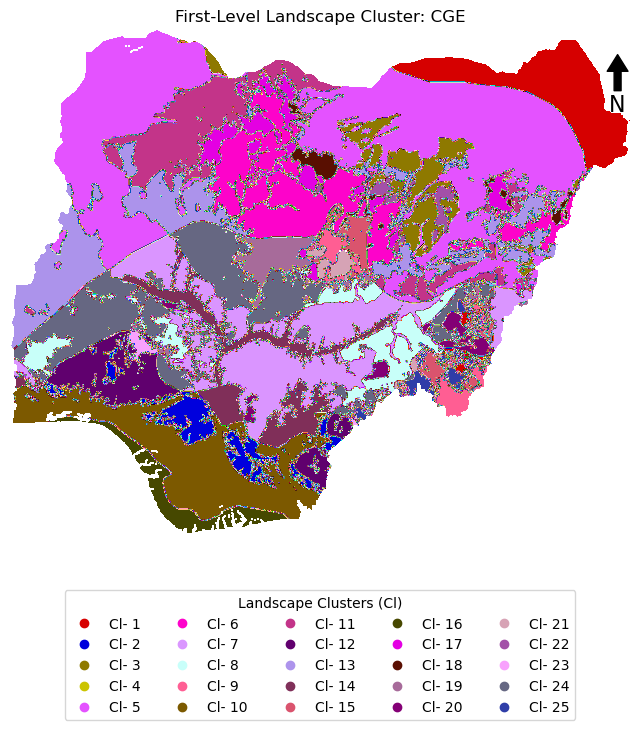

In [75]:
# Open the raster file
with rasterio.open('all_output/init_landscape_cge.tif') as src:
    fig, ax = plt.subplots(figsize=(8, 8))

    # Read the raster data
    raster = src.read(1)

    # Get unique values for the legend
    unique_values = np.unique(raster[raster > 0])  # Exclude NoData (0) values

    # Correct way to use colorcet's glasbey colormap
    cmap = cc.cm['glasbey']  # Accessing the 'glasbey' colormap from colorcet

    # Plot the raster using the correct transform and colormap
    im = rasterio.plot.show(src, ax=ax, cmap=cmap)

    # Add North Arrow
    x, y, arrow_length = 0.98, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=16, xycoords=ax.transAxes)

    # Add title
    ax.set_title('First-Level Landscape Cluster: CGE')

    # Generate colors from the colormap for the legend
    norm = plt.Normalize(vmin=unique_values.min(), vmax=unique_values.max())
    colors = [cmap(norm(value)) for value in unique_values]

    # Create legend entries and labels
    legend_entries = [Line2D([0], [0], marker='o', color=color, label=f"Cl- {type_value}", linestyle='', markersize=6)
                      for color, type_value in zip(colors, unique_values)]

    # Add the legend to the plot, positioned directly under the plot
    ax.legend(handles=legend_entries, title='Landscape Clusters (Cl)', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=5)

    # Remove the axis with the bounding box and coordinate values
    ax.axis('off')

    # Save the figure as both SVG and PNG files
    plt.savefig('all_output/init_landscape_clusters25.svg', format='svg', bbox_inches='tight')
    plt.savefig('all_output/init_landscape_clusters25.png', format='png', bbox_inches='tight')

    # Show the plot
    plt.show()

In [76]:
# Filter DataFrame
filtered_df_cgel = landscape_df_cgel[landscape_df_cgel['landscape_type'] > 0]

# Create GeoDataFrame
gdf_cgel = gpd.GeoDataFrame(
    filtered_df_cgel,
    geometry=gpd.points_from_xy(filtered_df_cgel.X, filtered_df_cgel.Y)
)

# Define CRS
crs = "EPSG:3857"
gdf_cgel = gdf_cgel.set_crs(crs)

# Get raster bounds and resolution
minx, miny, maxx, maxy = gdf_cgel.total_bounds
resolution = 1000  # Adjust resolution as needed

# Create raster from GeoDataFrame
out_shape = (int((maxy - miny) / resolution), int((maxx - minx) / resolution))
transform = from_origin(minx, maxy, resolution, resolution)

raster = rasterio.features.rasterize(
    ((geom, value) for geom, value in zip(gdf_cgel.geometry, gdf_cgel['landscape_type'])),
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype='int32'
)

# Write to GeoTIFF
# Create the raster file with a single band
cgel_raster_path = 'all_output/init_landscape_cgel.tif'

with rasterio.open(cgel_raster_path, 'w', driver='GTiff',
                  width=out_shape[1], height=out_shape[0], count=1,
                  dtype=raster.dtype, crs=crs, transform=transform) as dst:
    dst.nodata = 0
    dst.write(raster, 1)
    raster[raster == 0] = -9999  # Set 0 values to NoData

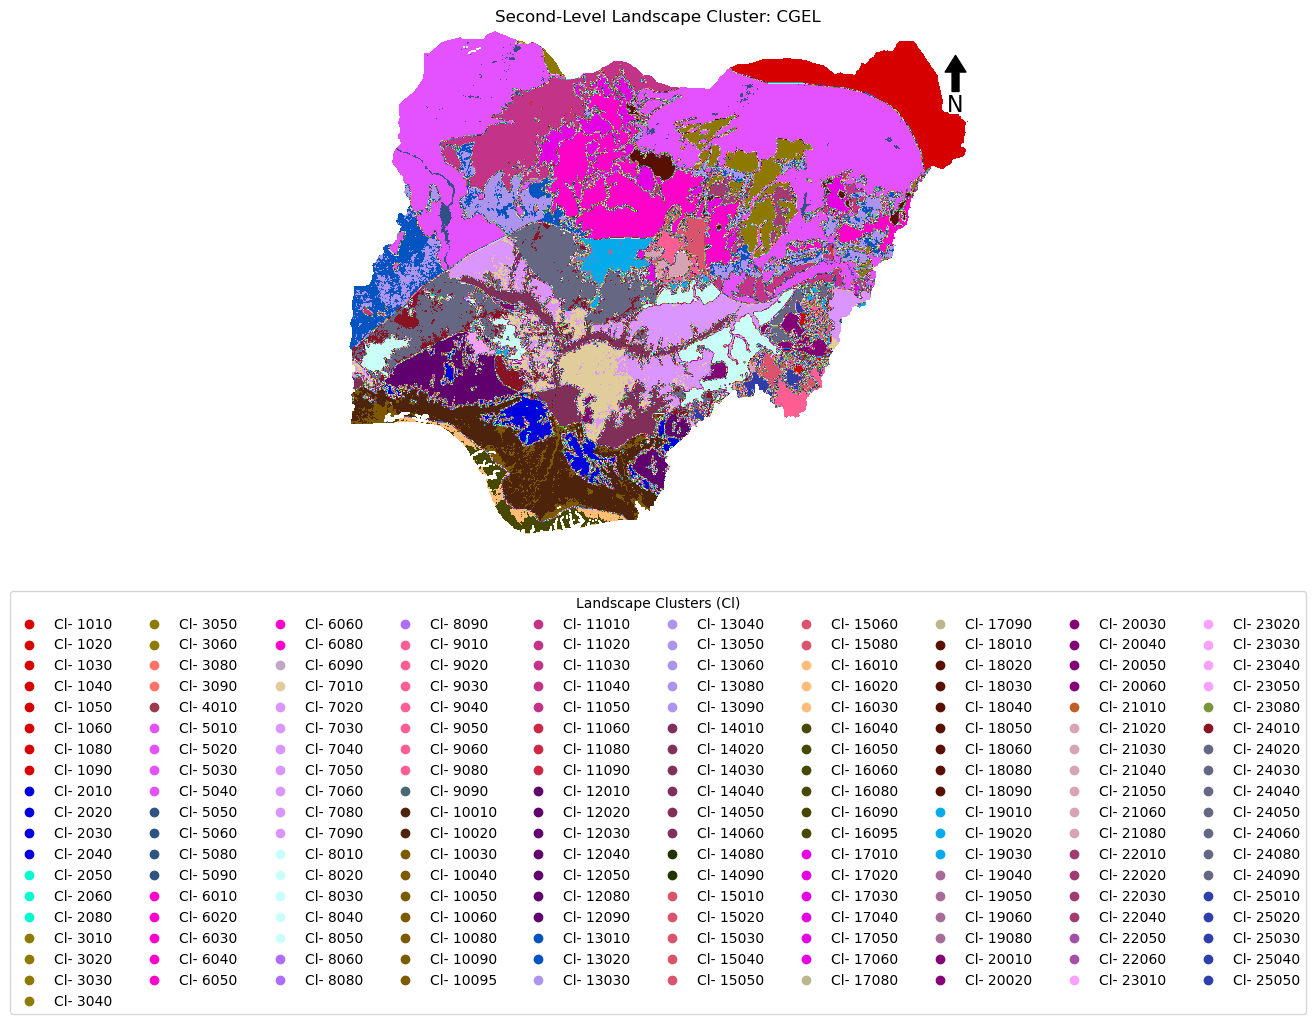

In [77]:
# Open the raster file
with rasterio.open('all_output/init_landscape_cgel.tif') as src:
    fig, ax = plt.subplots(figsize=(8, 8))

    # Read the raster data
    raster = src.read(1)

    # Get unique values for the legend
    unique_values = np.unique(raster[raster > 0])  # Exclude NoData (0) values

    # Correct way to use colorcet's glasbey colormap
    cmap = cc.cm['glasbey']  # Accessing the 'glasbey' colormap from colorcet

    # Plot the raster using the correct transform and colormap
    im = rasterio.plot.show(src, ax=ax, cmap=cmap)

    # Add North Arrow
    x, y, arrow_length = 0.98, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=16, xycoords=ax.transAxes)

    # Add title
    ax.set_title('Second-Level Landscape Cluster: CGEL')

    # Generate colors from the colormap for the legend
    norm = plt.Normalize(vmin=unique_values.min(), vmax=unique_values.max())
    colors = [cmap(norm(value)) for value in unique_values]

    # Create legend entries and labels
    legend_entries = [Line2D([0], [0], marker='o', color=color, label=f"Cl- {type_value}", linestyle='', markersize=6)
                      for color, type_value in zip(colors, unique_values)]

    # Add the legend to the plot, positioned directly under the plot
    ax.legend(handles=legend_entries, title='Landscape Clusters (Cl)', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10)

    # Remove the axis with the bounding box and coordinate values
    ax.axis('off')

    # Save the figure as both SVG and PNG files
    plt.savefig('all_output/init_landscape_clusters_all.svg', format='svg', bbox_inches='tight')
    plt.savefig('all_output/init_landscape_clusters_all.png', format='png', bbox_inches='tight')

    # Show the plot
    plt.show()

**3.2 Perform Majority Filters - Noise Reduction**

It is important to reduce the noise in the raster result, by using a Simple Majority Filter. As such, this will replace each pixel in a raster with the most common value among a defined neighborhood (5x5, 3x3, etc.), thus reduces noise and small isolated pixel artifacts that are evidently expressed in the (init) landscape raster data.

Original Raster Summary:
     Value   Count
0        0  505878
1     1010    1342
2     1020     929
3     1030   34506
4     1040    5213
..     ...     ...
177  25010    4713
178  25020     220
179  25030    1066
180  25040     364
181  25050       6

[182 rows x 2 columns]

Filtered Raster Summary:
     Value   Count
0        0  507928
1     1010    1331
2     1020     230
3     1030   36641
4     1040    3832
..     ...     ...
135  24090       4
136  25010    4889
137  25020      54
138  25030     816
139  25040     262

[140 rows x 2 columns]


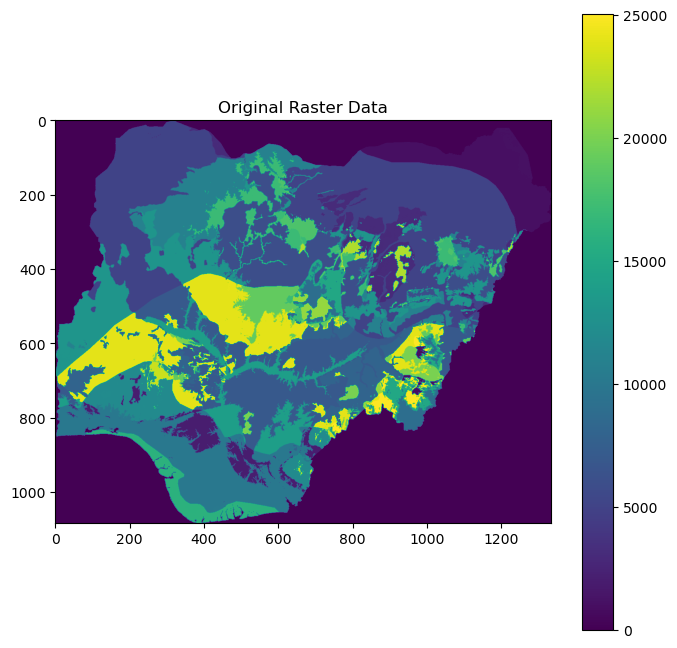

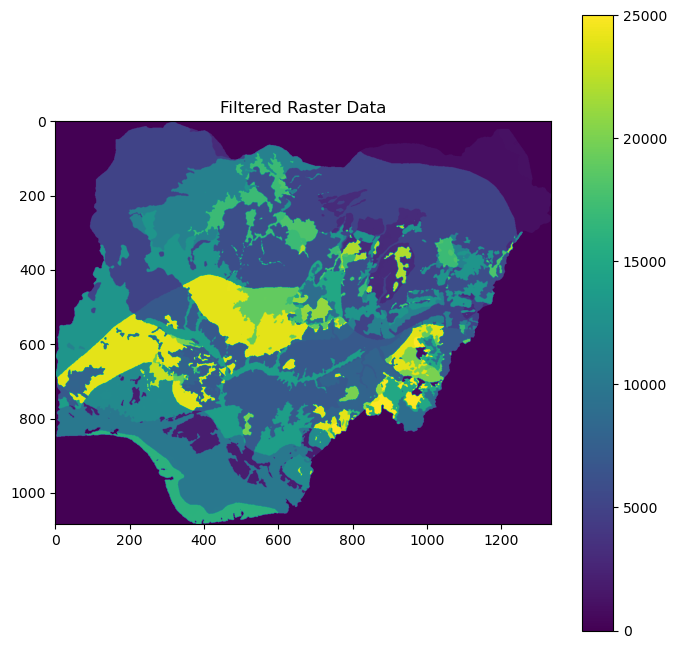

In [78]:
# Define the majority filter function
def majority_filter(values):
    values = values.astype(np.int64)  # Ensure values are integers
    counts = np.bincount(values)
    return np.argmax(counts)

# Function to apply the majority filter in parallel
def apply_majority_filter(data, block_info=None):
    data = data.astype(np.int64)  # Ensure data is in integer format
    filtered_block = generic_filter(data, majority_filter, size=5) # 5 x 5
    return filtered_block

# Set up Dask client and cluster
cluster = LocalCluster()
client = Client(cluster)

# Load the raster file
input_file = 'all_output/init_landscape_cgel.tif'
output_file = 'all_output/filtered_landscape_cgel.tif'

with rasterio.open(input_file) as src:
    data = src.read(1)  # Read the first band
    profile = src.profile

# Convert the data to a Dask array with appropriate chunking
dask_data = da.from_array(data, chunks=(1024, 1024))

# Apply the majority filter in parallel using Dask
filtered_dask_data = dask_data.map_blocks(apply_majority_filter, dtype=np.int64)

# Compute the result with progress bar
with ProgressBar():
    filtered_data = filtered_dask_data.compute()

# Save the filtered raster
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(filtered_data, 1)

# Close the Dask client and cluster
client.close()
cluster.close()

# Function to calculate summary statistics
def summarize_raster(data):
    unique, counts = np.unique(data, return_counts=True)
    summary = pd.DataFrame({'Value': unique, 'Count': counts})
    return summary

# Summarize original and filtered data
original_summary = summarize_raster(data)
filtered_summary = summarize_raster(filtered_data)

# Save the summaries to CSV file format
original_summary.to_csv('all_output/init_landscape_cgel.csv', index=True)
filtered_summary.to_csv('all_output/filtered_landscape_cgel.csv', index=True)

# Display summary statistics
print("Original Raster Summary:")
print(original_summary)

print("\nFiltered Raster Summary:")
print(filtered_summary)

# Function to plot raster data
def plot_raster(data, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Plot original and filtered data
plot_raster(data, 'Original Raster Data')
plot_raster(filtered_data, 'Filtered Raster Data')


**3.3 Convert Filtered Raster to Polygons and Create Landscape Character Areas - Polygons**

_Time_ Tracking...

In [79]:
from rasterio.features import shapes

# File paths
input_file = 'all_output/filtered_landscape_cgel.tif'
output_file = 'all_output/landscape_type_cgel.geojson'

# Read the filtered raster
with rasterio.open(input_file) as src:
    image = src.read(1)  # Read the first band
    mask = image != 0    # Create a mask for non-zero values
    transform = src.transform
    crs = src.crs  # Extract CRS from the original file

    # Polygonize the raster
    results = (
        {'properties': {'raster_val': int(v)}, 'geometry': s}
        for s, v in shapes(image, mask=mask, transform=transform)
    )

    # Convert to list for easy saving
    polygons = list(results)

# Define schema for GeoJSON
schema = {
    'geometry': 'Polygon',
    'properties': {'raster_val': 'int'},
}

# Save polygons to GeoJSON file with the original CRS
with fiona.open(output_file, 'w', driver='GeoJSON', crs=crs.to_dict(), schema=schema) as dst:
    for polygon in polygons:
        dst.write(polygon)

print("Conversion to GeoJSON completed successfully!")


Conversion to GeoJSON completed successfully!


***3.4 Remove Slivers (or Small Polygons)***

This process involves merging small polygons (< 5sq.km) to nearest, adjacent ones and finally, perform a morphological smoothening of the final landscape polygons.

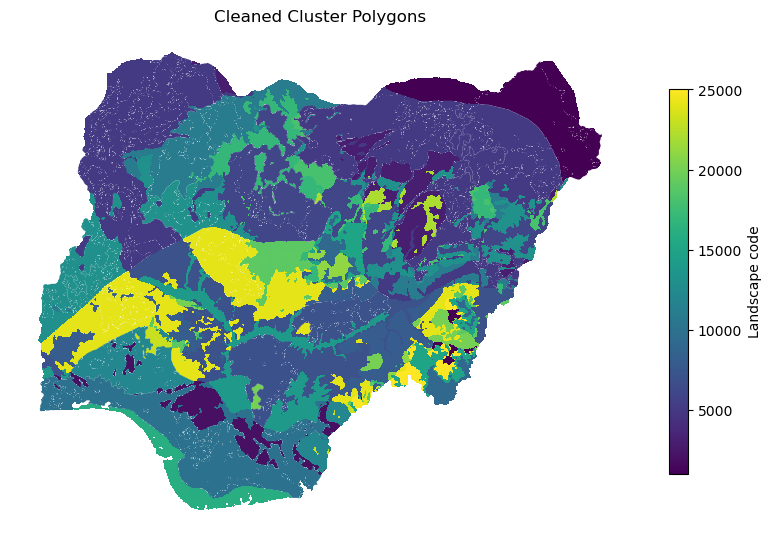

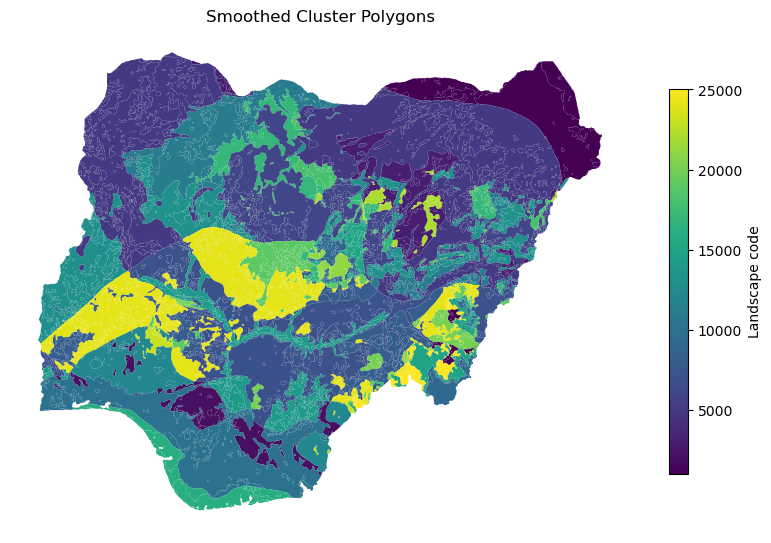

In [80]:
# Load the GeoJSON file into a GeoDataFrame
geojson_file = 'all_output/landscape_type_cgel.geojson'
gdf = gpd.read_file(geojson_file)

# Function to identify small polygons
def identify_small_polygons(gdf, min_area):
    gdf['area'] = gdf.geometry.area
    small_polygons = gdf[gdf['area'] < min_area]
    large_polygons = gdf[gdf['area'] >= min_area]
    return small_polygons, large_polygons

min_area_threshold = 5000000  # This is for any area less than 5 sq.km
small_polygons, large_polygons = identify_small_polygons(gdf, min_area_threshold)

# Function to find adjacent polygons
def find_adjacent_polygons(small_polygons, large_polygons):
    adjacent_info = []
    for small_poly in small_polygons.itertuples():
        small_geom = small_poly.geometry
        large_polys = large_polygons[large_polygons.geometry.touches(small_geom)]
        if not large_polys.empty:
            max_length = 0
            best_large_poly = None
            for large_poly in large_polys.itertuples():
                length = small_geom.intersection(large_poly.geometry).length
                if length > max_length:
                    max_length = length
                    best_large_poly = large_poly
            if best_large_poly:
                adjacent_info.append((small_poly.Index, best_large_poly.Index))
    return adjacent_info

adjacent_info = find_adjacent_polygons(small_polygons, large_polygons)

# Function to merge small polygons with adjacent larger polygons
def merge_small_polygons(gdf, adjacent_info):
    for small_idx, large_idx in adjacent_info:
        if small_idx in gdf.index and large_idx in gdf.index:
            gdf.at[large_idx, 'geometry'] = gdf.at[large_idx, 'geometry'].union(gdf.at[small_idx, 'geometry'])
            gdf = gdf.drop(small_idx)
    return gdf

# Function to smooth polygons using buffer and simplify
def smooth_polygons(gdf, buffer_distance, simplify_tolerance):
    # Buffer by a positive amount to smooth outward
    buffered_out = gdf.geometry.buffer(buffer_distance)
    
    # Buffer by a negative amount to smooth inward (retract to original size)
    buffered_in = buffered_out.buffer(-buffer_distance)
    
    # Simplify the geometry to reduce complexity
    smoothed = buffered_in.simplify(simplify_tolerance, preserve_topology=True)
    
    gdf['geometry'] = smoothed
    return gdf

# Ensure gdf is set as index and drop duplicates
gdf = gdf.reset_index(drop=True).drop_duplicates(subset='geometry')

# Merge small polygons with adjacent larger polygons
gdf = merge_small_polygons(gdf, adjacent_info)

# Save the cleaned polygons to GeoJSON
cleaned_geojson = 'all_output/cleaned_cluster_polygons.geojson'
gdf.to_file(cleaned_geojson, driver='GeoJSON')

# Plot the cleaned polygons
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='raster_val', ax=ax, legend=True, cmap='viridis',
                  legend_kwds={'shrink': 0.5, 'label': "Landscape code", 'orientation': "vertical"})
plt.title('Cleaned Cluster Polygons')
# Remove axis for cleaner presentation
ax.axis('off')
plt.show()

# Smooth the polygons
buffer_distance = 200  # Increase smoothing effect
simplify_tolerance = 0.1  # Increase simplify tolerance
smoothed_gdf = smooth_polygons(gdf, buffer_distance, simplify_tolerance)

# Save the cleaned and smoothed polygons to GeoJSON
smoothed_geojson = 'all_output/smoothed_cluster_polygons.geojson'
smoothed_gdf.to_file(smoothed_geojson, driver='GeoJSON')

# Plot the smoothed polygons
fig, ax = plt.subplots(figsize=(10, 10))
smoothed_gdf.plot(column='raster_val', ax=ax, legend=True, cmap='viridis',
                  legend_kwds={'shrink': 0.5, 'label': "Landscape code", 'orientation': "vertical"})
plt.title('Smoothed Cluster Polygons')
# Remove axis for cleaner presentation
ax.axis('off')
plt.show()

**3.5 Populate the Database of the Landscape Character Types/Areas**

This is done using the dataframe earlier created for the landscape elemente. Population of the attribute table will be based on majority of aggregated elements.


In [81]:
# Load the GeoJSON file into a GeoDataFrame
smoothed_geojson = 'all_output/smoothed_cluster_polygons.geojson'
gdf = gpd.read_file(smoothed_geojson)

# Ensure the 'raster_val' column exists in gdf and 'landscape_type' in landscape_df_cge
if 'raster_val' not in gdf.columns:
    raise KeyError("The column 'raster_val' is not found in the GeoDataFrame 'gdf'.")
if 'landscape_type' not in landscape_df_cge.columns:
    raise KeyError("The column 'landscape_type' is not found in the DataFrame 'landscape_df_cge'.")

# Drop the "area" column since it is not the actual area of each polygon rather, refers to pixel sizes...
if 'area' in gdf.columns:
    gdf = gdf.drop(columns=['area'])

# Calculate the actual area of each polygon in square kilometers
gdf['area_sqkm'] = gdf.geometry.area / 10**6  # Convert from square meters to square kilometers

# Define aggregation functions for each relevant attribute
aggregation_functions = {
    'Elevation': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Climate': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Landcover': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Geology': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Cluster25': lambda x: x.mode()[0] if not x.mode().empty else None,
    'land_code25': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Elevation_Class': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Climate_Class': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Landcover_Class': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Geology_Class': lambda x: x.mode()[0] if not x.mode().empty else None,
    'complete_code': lambda x: x.mode()[0] if not x.mode().empty else None,
    'mLST': 'mean'
}

# Aggregate the landscape_df_cge DataFrame by 'landscape_type'
landscape_df_cge_aggregated = landscape_df_cge.groupby('landscape_type').agg(aggregation_functions).reset_index()

# Rename 'landscape_type' in the aggregated DataFrame to 'raster_val' to match the GeoDataFrame
landscape_df_cge_aggregated = landscape_df_cge_aggregated.rename(columns={'landscape_type': 'raster_val'})

# Merge the aggregated data with the GeoDataFrame
gdf_joined = gdf.merge(landscape_df_cge_aggregated, on='raster_val', how='left')

# Calculate the total area and the number of patches for each `complete_code`
code_stats = gdf_joined.groupby('complete_code').agg({
    'area_sqkm': 'sum',
    'geometry': 'count'  # Number of patches
}).rename(columns={'area_sqkm': 'total_area', 'geometry': 'num_patches'}).reset_index()

# Merge the calculated statistics back into the GeoDataFrame
gdf_joined = gdf_joined.merge(code_stats, on='complete_code', how='left')

# Check if columns are correctly named after merging
print(gdf_joined.columns)

# Create the descriptive sentence
gdf_joined['description'] = (
    "A predominantly " + gdf_joined['Landcover_Class'] + " type of land cover with a " +
    gdf_joined['Climate_Class'] + " climate type, in a predominantly " +
    gdf_joined['Geology_Class'] + " formation and situated mainly in a " +
    gdf_joined['Elevation_Class'] + " altitude. It makes up about " +
    gdf_joined['area_sqkm'].round(2).astype(str) + " sq.km and a total of " +
    gdf_joined['total_area'].round(2).astype(str) + " sq.km across the entire study area, with " +
    gdf_joined['num_patches'].astype(str) + " patches."
)

# Convert the whole description to have the first letter capitalized (proper sentence casing)
gdf_joined['description'] = gdf_joined['description'].str.lower().str.capitalize()

# Ensure gdf_joined is a GeoDataFrame and set the geometry column
gdf_joined = gpd.GeoDataFrame(gdf_joined, geometry='geometry', crs=gdf.crs)

# Define output file paths
output_geojson_path = 'all_output/complete_landscape_ch_polygons.geojson'
output_shapefile_path = 'all_output/complete_landscape_ch_polygons.shp'

# Save to GeoJSON to avoid file size limitations
gdf_joined.to_file(output_geojson_path, driver='GeoJSON')

# Save to Shapefile
gdf_joined.to_file(output_shapefile_path, driver='ESRI Shapefile')

# Display the saved file paths for verification
print(f'GeoJSON saved to: {output_geojson_path}')
print(f'Shapefile saved to: {output_shapefile_path}')

# Display the merged GeoDataFrame to verify the results
print(gdf_joined['description'].tail())

Index(['raster_val', 'geometry', 'area_sqkm', 'Elevation', 'Climate',
       'Landcover', 'Geology', 'Cluster25', 'land_code25', 'Elevation_Class',
       'Climate_Class', 'Landcover_Class', 'Geology_Class', 'complete_code',
       'mLST', 'total_area', 'num_patches'],
      dtype='object')


C:\Users\EnechePSU\AppData\Local\Temp\ipykernel_25912\80666959.py:80: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_joined.to_file(output_shapefile_path, driver='ESRI Shapefile')


GeoJSON saved to: all_output/complete_landscape_ch_polygons.geojson
Shapefile saved to: all_output/complete_landscape_ch_polygons.shp
4588    A predominantly tree cover type of land cover ...
4589    A predominantly tree cover type of land cover ...
4590    A predominantly waterbody type of land cover w...
4591    A predominantly mangroves type of land cover w...
4592    A predominantly tree cover type of land cover ...
Name: description, dtype: object


**4.0 VISUALIZATION**

**4.1 First-Level Landscape Character Areas - Climate|Geology|Elevation**



C:\Users\EnechePSU\AppData\Local\Temp\ipykernel_25912\1425522408.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20c_r', num_colors)  # Use a colormap with enough distinct colors
c:\Users\EnechePSU\.conda\envs\gee\envs\geemap-env\lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


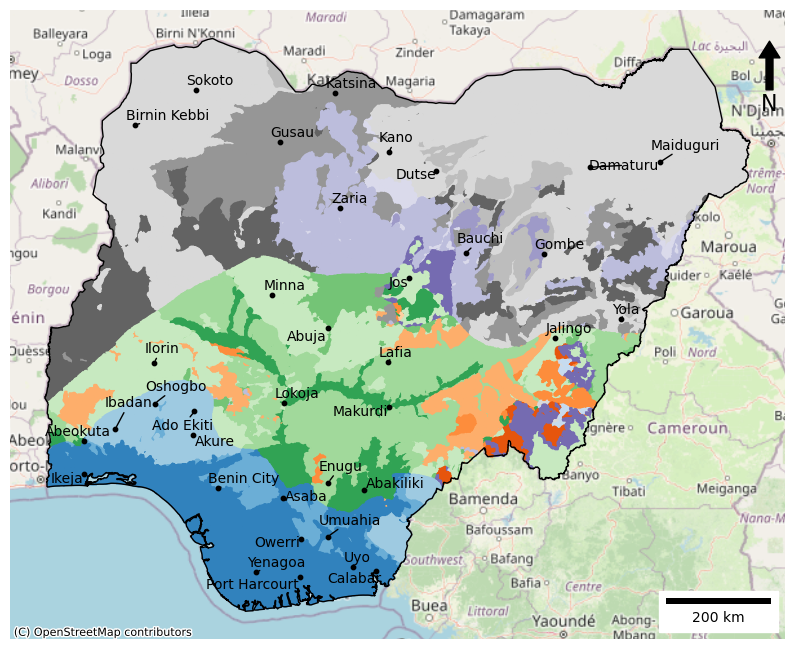

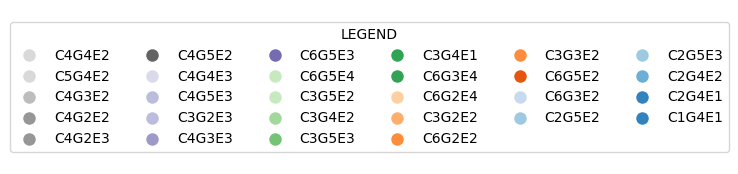

In [82]:
# Load datasets
nigeria_boundary = gpd.read_file('all_input_dataset/nig_bounds.geojson')
gdf_state_capitals = gpd.read_file('all_input_dataset/nig_major_cities.geojson')
nigeria_states = gpd.read_file('all_input_dataset/nig_state_bounds.geojson')

# Ensure the CRS matches across GeoDataFrames
if nigeria_boundary.crs != gdf_joined.crs:
    nigeria_boundary = nigeria_boundary.to_crs(gdf_joined.crs)
    
if gdf_state_capitals.crs != gdf_joined.crs:
    gdf_state_capitals = gdf_state_capitals.to_crs(gdf_joined.crs)

if nigeria_states.crs != gdf_joined.crs:
    nigeria_states = nigeria_states.to_crs(gdf_joined.crs)


# First-level character types are contained in the column named "land-code25"..
gdf_joined['land_code25'] = gdf_joined['land_code25'].astype(str)
gdf_joined = gdf_joined.dropna(subset=['land_code25'])

# Create a colormap with a RANDOM number of colors equal to the number of unique values in the column
unique_codes = gdf_joined['land_code25'].unique()
num_colors = len(unique_codes)
cmap = plt.cm.get_cmap('tab20c_r', num_colors)  # Use a colormap with enough distinct colors

# Assign colors to each unique values found...
colors = {code: cmap(i) for i, code in enumerate(unique_codes)}

# Plot the GeoDataFrame with Basemap (from OpenStreetMap)
fig, ax = plt.subplots(figsize=(10, 10))
gdf_joined.plot(column='land_code25', ax=ax, color=gdf_joined['land_code25'].map(colors), edgecolor=gdf_joined['land_code25'].map(colors))

# Adding a basemap (requires gdf_joined to be in EPSG:3857)
ctx.add_basemap(ax, crs=gdf_joined.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Add state capital names and adjust positions
texts = []
for x, y, label in zip(gdf_state_capitals.geometry.x, gdf_state_capitals.geometry.y, gdf_state_capitals['Name']):
    texts.append(ax.text(x, y, label, fontsize=10, ha='right', color='black'))
adjust_text(texts, ax=ax, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="-", color='black'))

# Overlay Nigeria boundary as a hollow (transparent fill) boundary layer
nigeria_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='-', label='Nigeria Boundary')

# Overlay state capitals as points
gdf_state_capitals.plot(ax=ax, color='black', markersize=10, label='State Capitals')

# Add North Arrow
x, y, arrow_length = 0.98, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=16, xycoords=ax.transAxes)

# Add Scale Bar
scalebar = ScaleBar(dx=1, units='m', location='lower right', pad=0.5, border_pad=0.5, sep=5, length_fraction=0.25)
ax.add_artist(scalebar)

# Remove axis for cleaner presentation
ax.axis('off')

# Save the map without the legend if desired
plt.savefig('all_output/1st_level_lc_without_legend.png', bbox_inches='tight')
plt.savefig('all_output/1st_level_lc_without_legend.svg', bbox_inches='tight')

# Create a separate figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(3, 2))  # Adjust the figsize for legend height
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"{code}",
                          markerfacecolor=colors[code], markersize=10) for code in unique_codes]

# Add the legend to a separate figure
ax_legend.legend(handles=legend_elements, title="LEGEND", loc='center', ncol=6)
ax_legend.axis('off')  # Turn off the axis for the legend figure

# Save the legend as a separate image if desired
plt.savefig('all_output/1st_level_lc_legend.png', bbox_inches='tight')
plt.savefig('all_output/1st_level_lc_legend.svg', bbox_inches='tight')

# Display the map and legend separately
plt.show()


**4.2 Second-Level Landscape Character Types**

_**4.2.1 Use of a Dynamic Color Ramp**_

In [83]:
# Define primary colors based on each land cover class
primary_colors = {
    'Tree Cover': '#32CD32',    # Lime Green
    'Shrubland': '#FFBB22',     # Orange
    'Grassland': '#FFFF4C',     # Yellow
    'Cropland': '#F096FF',      # Light Purple
    'Built-up': '#FA0000',      # Red
    'Bareland': '#B4B4B4',      # Grey
    'Waterbody': '#0064C8',     # Blue
    'Wetland': '#008080',       # Teal
    'Mangroves': '#00CF75'      # Greenish Teal
}

# Function to generate a list of related colors within the same color family
def generate_color_variants(base_color, num_variants):
    """Generates a list of color variants within the same color family."""
    base_rgb = np.array(mcolors.to_rgb(base_color))
    base_hls = colorsys.rgb_to_hls(*base_rgb)
    
    colors = []
    for i in range(num_variants):
        variant_hls = (
            base_hls[0],  # Keep the hue the same
            max(0, min(1, base_hls[1] * (0.7 + 0.3 * i / (num_variants - 1)))),  # Adjust lightness
            max(0, min(1, base_hls[2] * (0.7 + 0.3 * i / (num_variants - 1))))   # Adjust saturation
        )
        variant_rgb = colorsys.hls_to_rgb(*variant_hls)
        colors.append(mcolors.to_hex(variant_rgb))
    
    return colors

# Function to generate color scheme and add it to the GeoDataFrame (as: color_auto)
def generate_color_scheme(gdf, primary_colors):
    """Generates color codes and adds them to the GeoDataFrame."""
    color_dict = {}
    
    for category, base_color in primary_colors.items():
        # Filter subcategories for the current primary category
        category_codes = sorted(gdf[gdf['Landcover_Class'] == category]['complete_code'].unique())
        
        # Generate color variants for these subcategories
        num_variants = len(category_codes)
        color_variants = generate_color_variants(base_color, num_variants)
        
        # Map these color variants to the corresponding codes
        color_dict[category] = {}
        for code, color in zip(category_codes, color_variants):
            color_dict[category][code] = color

    # Add color codes to the GeoDataFrame
    gdf['color_auto'] = gdf['complete_code'].map({code: color for sub_dict in color_dict.values() for code, color in sub_dict.items()})
    
    return gdf, color_dict  # Return both gdf and color_dict

# Generate the color scheme and add it to gdf_joined
gdf_joined, color_dict = generate_color_scheme(gdf_joined, primary_colors)

# Now, the dataframe (gdf_joined) has a 'color' column that you can be used for plotting

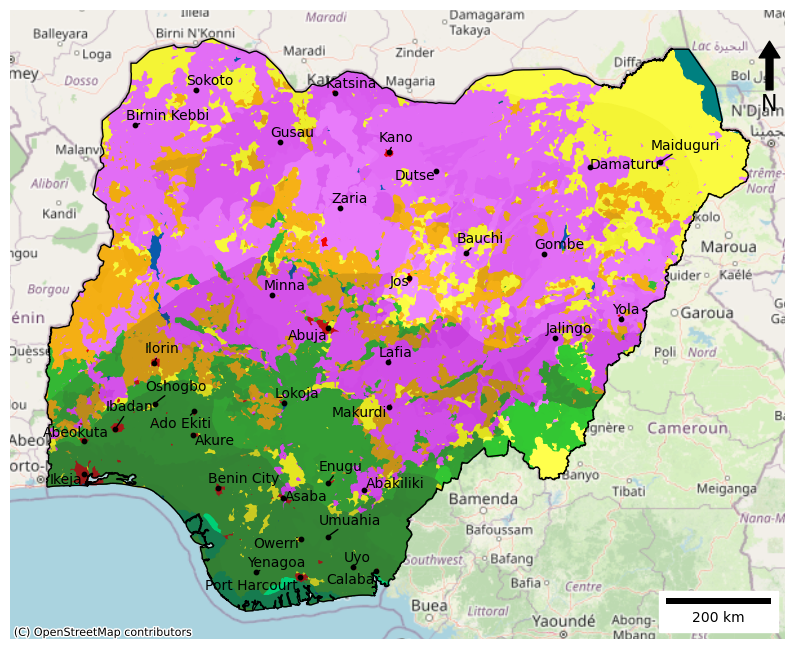

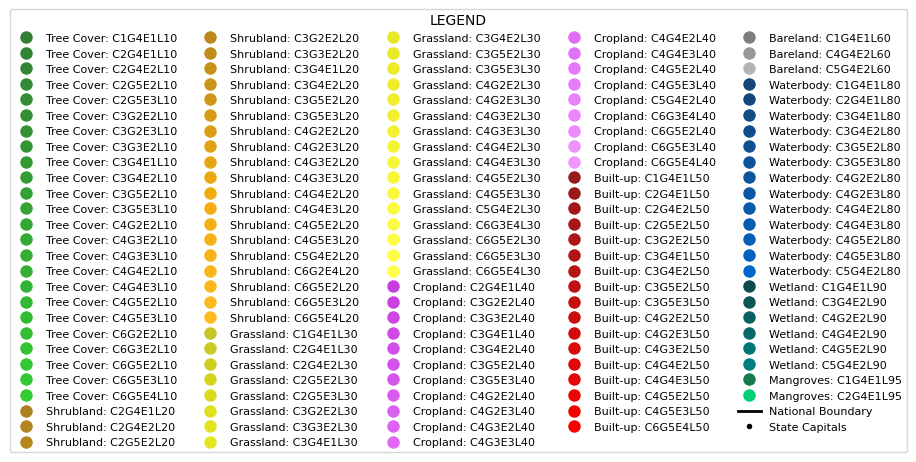

In [84]:
# Plot the GeoDataFrame with Basemap
fig, ax = plt.subplots(figsize=(10, 10))
gdf_joined.plot(ax=ax, color=gdf_joined['color_auto'], edgecolor=gdf_joined['color_auto'])

# Adding a basemap (requires gdf_joined to be in EPSG:3857, which it is)
ctx.add_basemap(ax, crs=gdf_joined.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Overlay Nigeria boundary as a hollow (transparent fill) boundary layer
nigeria_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='-', label='Nigeria Boundary')

# Overlay state capitals as points
gdf_state_capitals.plot(ax=ax, color='black', markersize=10, label='State Capitals')

# Add state capital names and use adjust_text to avoid overlap
texts = []
for x, y, label in zip(gdf_state_capitals.geometry.x, gdf_state_capitals.geometry.y, gdf_state_capitals['Name']):
    texts.append(ax.text(x, y, label, fontsize=10, ha='right', color='black'))

# Adjust text positions to prevent overlap
adjust_text(texts, ax=ax, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="-", color='black'))

# Add North Arrow (moved to top right)
x, y, arrow_length = 0.98, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=16, xycoords=ax.transAxes)

# Add Scale Bar (ensure correct units)
scalebar = ScaleBar(dx=1, units='m', location='lower right', pad=0.5, border_pad=0.5, sep=5, length_fraction=0.25)
ax.add_artist(scalebar)

#Remove axis for cleaner presentation
ax.axis('off')

# Save the map without the legend
plt.savefig('all_output/2nd_level_lc_without_legend.png', bbox_inches='tight')
plt.savefig('all_output/2nd_level_lc_without_legend.svg', bbox_inches='tight')

# Create a separate figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(7, 3))  # Adjust the figsize for legend height
legend_elements = []
for category, codes in color_dict.items():
    for code, color in codes.items():
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f"{category}: {code}",
                                      markerfacecolor=color, markersize=10))

# Add entries for the new layers
legend_elements.append(Line2D([0], [0], color='black', lw=2, label='National Boundary'))
legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='State Capitals'))

# Add the legend to a separate figure
ax_legend.legend(handles=legend_elements, title="LEGEND", loc='center', ncol=5, fontsize='8')
ax_legend.axis('off')  # Turn off the axis for the legend figure

# Save the legend as a separate image
plt.savefig('all_output/2nd_level_lc_legend.png', bbox_inches='tight')
plt.savefig('all_output/2nd_level_lc_legend.svg', bbox_inches='tight')

# Display the map and legend separately
plt.show()

**4.2.2 Use of a Controlled Color Dictionary**

In [85]:
color_dict = {
    'Tree Cover': {
        'C3G5E2L10': '#32CD32',
        'C3G4E2L10': '#228B22',
        'C3G4E1L10': '#6B8E23',
        'C3G5E3L10': '#2E8B57',
        'C3G2E2L10': '#98FF98',
        'C4G5E3L10': '#01796F',
        'C4G5E2L10': '#00A86B',
        'C2G4E2L10': '#4CBB17',
        'C2G4E1L10': '#008080',
        'C6G5E2L10': '#7FFF00',
        'C6G5E3L10': '#355E3B',
        'C1G4E1L10': '#8A9A5B',
        'C6G5E4L10': '#50C878',
        'C4G4E2L10': '#4B5320',
        'C3G2E3L10': '#3EA055',
        'C6G2E2L10': '#7CFC00',
        'C2G5E3L10': '#009E60',
        'C3G3E2L10': '#D1E231',
        'C6G3E2L10': '#568203',
        'C4G2E2L10': '#4F7942',
        'C2G5E2L10': '#9DC183',
        'C4G4E3L10': '#93C572',
        'C4G3E2L10': '#ADF802',
        'C4G3E3L10': '#3FFF00'
        # Additional entries with 'x' can be left out or marked as undefined
    },
    'Shrubland': {
        'C4G4E2L20': '#ffbb22',
        'C3G4E2L20': '#CC5500',
        'C3G5E2L20': '#F28500',
        'C4G5E2L20': '#FF7518',
        'C4G5E3L20': '#FF7F50',
        'C3G4E1L20': '#FFDAB9',
        'C3G2E2L20': '#ED9121',
        'C4G2E2L20': '#FFBF00',
        'C3G5E3L20': '#FA8072',
        'C4G4E3L20': '#FFA62B',
        'C4G3E2L20': '#FBCEB1',
        'C6G5E3L20': '#FFC324',
        'C4G2E3L20': '#E69500',
        'C6G5E4L20': '#B87333',
        'C4G3E3L20': '#FE6F5E',
        'C3G3E2L20': '#FFD067',
        'C5G4E2L20': '#EC5800',
        'C2G4E2L20': '#D2691E',
        'C2G4E1L20': '#FD5E53',
        'C6G2E4L20': '#FD6A02',
        'C6G5E2L20': '#E34234',
        'C2G5E2L20': '#F5A623',
        # Additional entries, if any...
    },
    'Grassland': {
        'C4G4E2L30': '#ffff4c',
        'C4G5E2L30': '#FFF44F',
        'C4G5E3L30': '#FFEF00',
        'C4G2E2L30': '#DAA520',
        'C3G5E2L30': '#FFC512',
        'C2G4E1L30': '#FFD700',
        'C3G4E1L30': '#FFFD78',
        'C3G4E2L30': '#FFFF31',
        'C4G2E3L30': '#FFDB58',
        'C4G4E3L30': '#EEDC82',
        'C3G5E3L30': '#F4C430',
        'C6G5E3L30': '#FADA5E',
        'C3G2E2L30': '#F8DE7E',
        'C6G5E4L30': '#FFBF00',
        'C4G3E2L30': '#F8F4A6',
        'C2G4E2L30': '#FFE135',
        'C6G3E4L30': '#FED85D',
        'C6G5E2L30': '#E4D96F',
        'C3G3E2L30': '#FFF1B5',
        'C5G4E2L30': '#FBEC5D',
        'C4G3E3L30': '#EED202',
        'C1G4E1L30': '#FFD300',
        'C2G5E3L30': '#FDFD96',
        'C2G5E2L30': '#FFCA4B'
        # Additional entries, if any...
    },
    'Cropland': {
        'C4G4E2L40': '#f096ff',
        'C4G5E2L40': '#E08CFF',
        'C3G4E2L40': '#D486FF',
        'C3G4E1L40': '#C880FF',
        'C4G2E2L40': '#B47AFF',
        'C4G5E3L40': '#FF96F0',
        'C3G2E2L40': '#FF8CEA',
        'C5G4E2L40': '#FF82E4',
        'C4G2E3L40': '#FF78DE',
        'C4G3E2L40': '#FF96D4',
        'C6G5E3L40': '#FF96C8',
        'C6G5E4L40': '#FF96BC',
        'C4G3E3L40': '#FF96B0',
        'C3G3E2L40': '#FFA0FF',
        'C6G3E4L40': '#FFA6FF',
        'C6G5E2L40': '#FFACFF',
        'C3G5E3L40': '#FFB2FF',
        'C4G4E3L40': '#FFAFB0',
        'C3G5E2L40': '#FFBAB0',
        'C2G4E1L40': '#FFB8FF'
        # Additional entries, if any...
    },
    'Built-up': {
        'C2G4E1L50': '#fa0000',
        'C2G5E2L50': '#DC143C',
        'C3G5E2L50': '#FF2400',
        'C3G4E2L50': '#B22222',
        'C4G4E2L50': '#960018',
        'C2G4E2L50': '#FF0800',
        'C1G4E1L50': '#FF6347',
        'C3G4E1L50': '#CD5C5C',
        'C3G2E2L50': '#CB4154',
        'C4G5E2L50': '#8A0707',
        'C3G5E3L50': '#65000B',
        'C4G2E3L50': '#800020',
        'C4G5E3L50': '#D2042D',
        'C4G2E2L50': '#B7410E',
        'C4G3E2L50': '#FA8072',
        'C4G4E3L50': '#9B111E',
        'C6G5E4L50': '#800000'
        # Additional entries...
    },
    'Bareland': {
        'C4G4E2L60': '#b4b4b4',
        'C5G4E2L60': '#9696A3',
        'C1G4E1L60': '#D2D2E3'
        # Additional entries...
    },
    'Waterbody': {
        'C4G4E2L80': '#0064C8',
        'C3G4E1L80': '#1E90FF',
        'C3G5E2L80': '#0047AB',
        'C2G4E1L80': '#007FFF',
        'C1G4E1L80': '#0F52BA',
        'C4G2E2L80': '#4169E1',
        'C4G5E3L80': '#007BA7',
        'C5G4E2L80': '#003153',
        'C3G5E3L80': '#3F00FF',
        'C4G5E2L80': '#002147',
        'C4G4E3L80': '#00BFFF',
        'C4G2E3L80': '#7DF9FF',
        'C3G4E2L80': '#5D8AA8',
        'C3G2E2L80': '#000080'
        # Additional entries...
    },
    'Wetland': {
        'C4G4E2L90': '#008080',
        'C5G4E2L90': '#00755E',
        'C1G4E1L90': '#009698',
        'C4G2E2L90': '#5F9EA0',
        'C4G5E2L90': '#007F66',
        'C3G4E2L90': '#0095B6',
        # Additional entries...
    },
    'Mangroves': {
        'C2G4E1L95': '#00cf75',
        'C1G4E1L95': '#00DD7D'
        # Additional entries...
    }
}

# Assuming gdf is your GeoDataFrame and 'complete_code' is the column containing the complete code list
complete_code_list = gdf_joined['complete_code'].unique()

# Flatten all existing complete_codes in the color_dict
existing_codes = set()
for category in color_dict.values():
    existing_codes.update(category.keys())

# Find undefined complete_code members
undefined_codes = [code for code in complete_code_list if code not in existing_codes]

# Output undefined complete_code members
if undefined_codes:
    print("The following landscape character types have no defined color:")
    for code in undefined_codes:
        print(code)
else:
    print("All landscape character types present have defined colors.")


All landscape character types present have defined colors.


In [86]:
# Create a color mapping function
def get_color(complete_code):
    for category, codes in color_dict.items():
        if complete_code in codes:
            return codes[complete_code]
    return '#000000'  # Default color for undefined codes

# Apply the color mapping
gdf_joined['color'] = gdf_joined['complete_code'].apply(get_color)

# Define output file paths
output_geojson_path = 'all_output/complete_landscape_ch_polygons_colors.geojson'
output_shapefile_path = 'all_output/complete_landscape_ch_polygons_colors.shp'

# Save to GeoJSON to avoid file size limitations
gdf_joined.to_file(output_geojson_path, driver='GeoJSON')

# Save to Shapefile
gdf_joined.to_file(output_shapefile_path, driver='ESRI Shapefile')

# Display the saved file paths for verification
print(f'Updated GeoJSON saved to: {output_geojson_path}')
print(f'Updated Shapefile saved to: {output_shapefile_path}')

C:\Users\EnechePSU\AppData\Local\Temp\ipykernel_25912\899343941.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_joined.to_file(output_shapefile_path, driver='ESRI Shapefile')


Updated GeoJSON saved to: all_output/complete_landscape_ch_polygons_colors.geojson
Updated Shapefile saved to: all_output/complete_landscape_ch_polygons_colors.shp


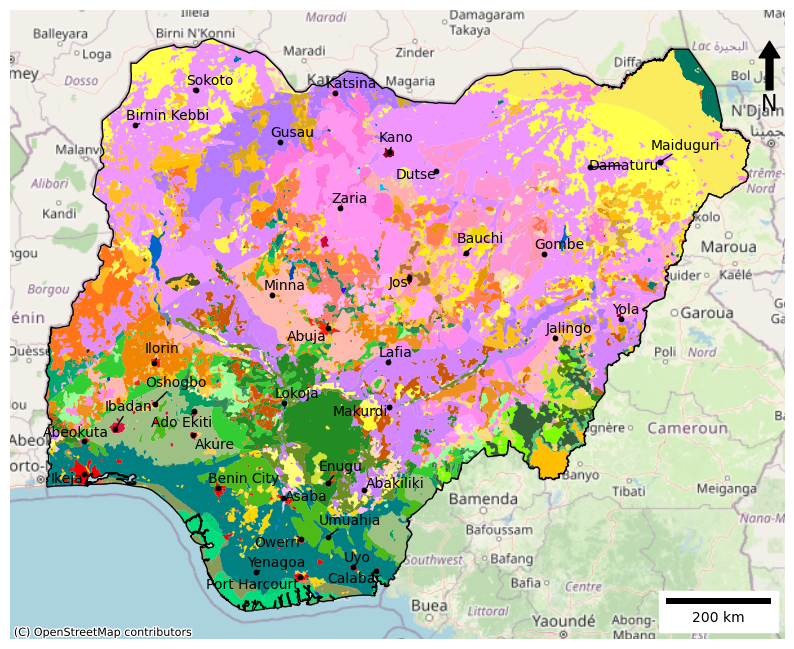

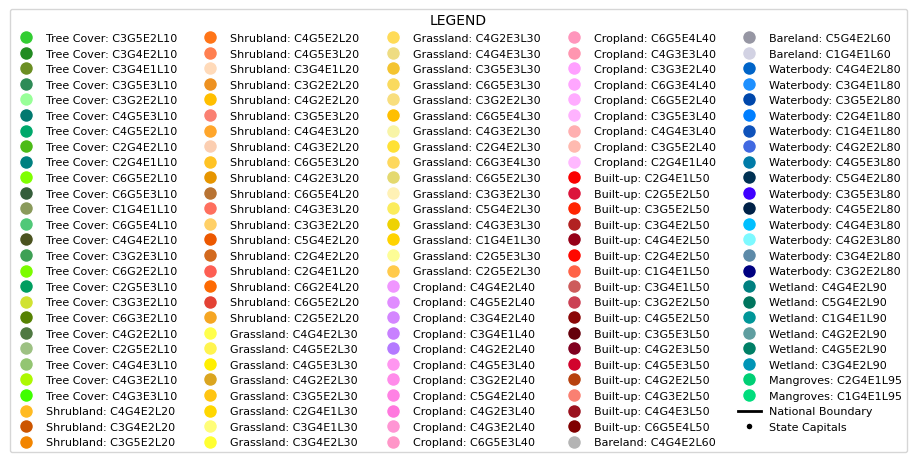

In [87]:
# Plot the GeoDataFrame with Basemap
fig, ax = plt.subplots(figsize=(10, 10))
gdf_joined.plot(ax=ax, color=gdf_joined['color'], edgecolor=None)  # Plot the main data without outlines

# Adding a basemap (requires gdf_joined to be in EPSG:3857, which it is)
ctx.add_basemap(ax, crs=gdf_joined.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Overlay Nigeria boundary as a hollow (transparent fill) boundary layer
nigeria_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='-', label='Nigeria Boundary')

# Overlay state capitals as points
gdf_state_capitals.plot(ax=ax, color='black', markersize=10, label='State Capitals')

# Add state capital names and use adjust_text to avoid overlap
texts = []
for x, y, label in zip(gdf_state_capitals.geometry.x, gdf_state_capitals.geometry.y, gdf_state_capitals['Name']):
    texts.append(ax.text(x, y, label, fontsize=10, ha='right', color='black'))

# Adjust text positions to prevent overlap
adjust_text(texts, ax=ax, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="-", color='black'))

# Add North Arrow (moved to top right)
x, y, arrow_length = 0.98, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=16, xycoords=ax.transAxes)

# Add Scale Bar (ensure correct units)
scalebar = ScaleBar(dx=1, units='m', location='lower right', pad=0.5, border_pad=0.5, sep=5, length_fraction=0.25)
ax.add_artist(scalebar)

# Remove axis for cleaner presentation
ax.axis('off')

# Save the map without the legend
output_dir = 'all_output'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, '2nd_level_lc_without_legend_v2.png'), bbox_inches='tight')
plt.savefig(os.path.join(output_dir, '2nd_level_lc_without_legend_v2.svg'), bbox_inches='tight')

# Create a separate figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(7, 3))  # Adjust the figsize for legend height
legend_elements = []

# Add landscape character codes to the legend
for category, codes in color_dict.items():
    for code, color in codes.items():
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f"{category}: {code}",
                                      markerfacecolor=color, markersize=10))

# Add entries for the new layers
legend_elements.append(Line2D([0], [0], color='black', lw=2, label='National Boundary'))
legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='State Capitals'))

# Add the legend to a separate figure
ax_legend.legend(handles=legend_elements, title="LEGEND", loc='center', ncol=5, fontsize='8')
ax_legend.axis('off')  # Turn off the axis for the legend figure

# Save the legend as a separate image
plt.savefig(os.path.join(output_dir, '2nd_level_lc_legend_v2.png'), bbox_inches='tight')
plt.savefig(os.path.join(output_dir, '2nd_level_lc_legend_v2.svg'), bbox_inches='tight')

# Display the map and legend separately
plt.show()


**4.3 Areal Proportion of Different Landscape Character Types**

       Cluster     Total Area  Percent Area    Color  Percent Clusters
83   C4G4E2L40  125067.943607     13.305613  #f096ff          3.244067
82   C4G4E2L30   58749.026481      6.250137  #ffff4c          6.335728
7    C2G4E1L10   57751.318921      6.143994  #008080          0.718485
43   C3G4E2L40   40712.830776      4.331319  #D486FF          2.351404
104  C4G5E3L40   38473.341559      4.093066  #FF96F0          1.328108


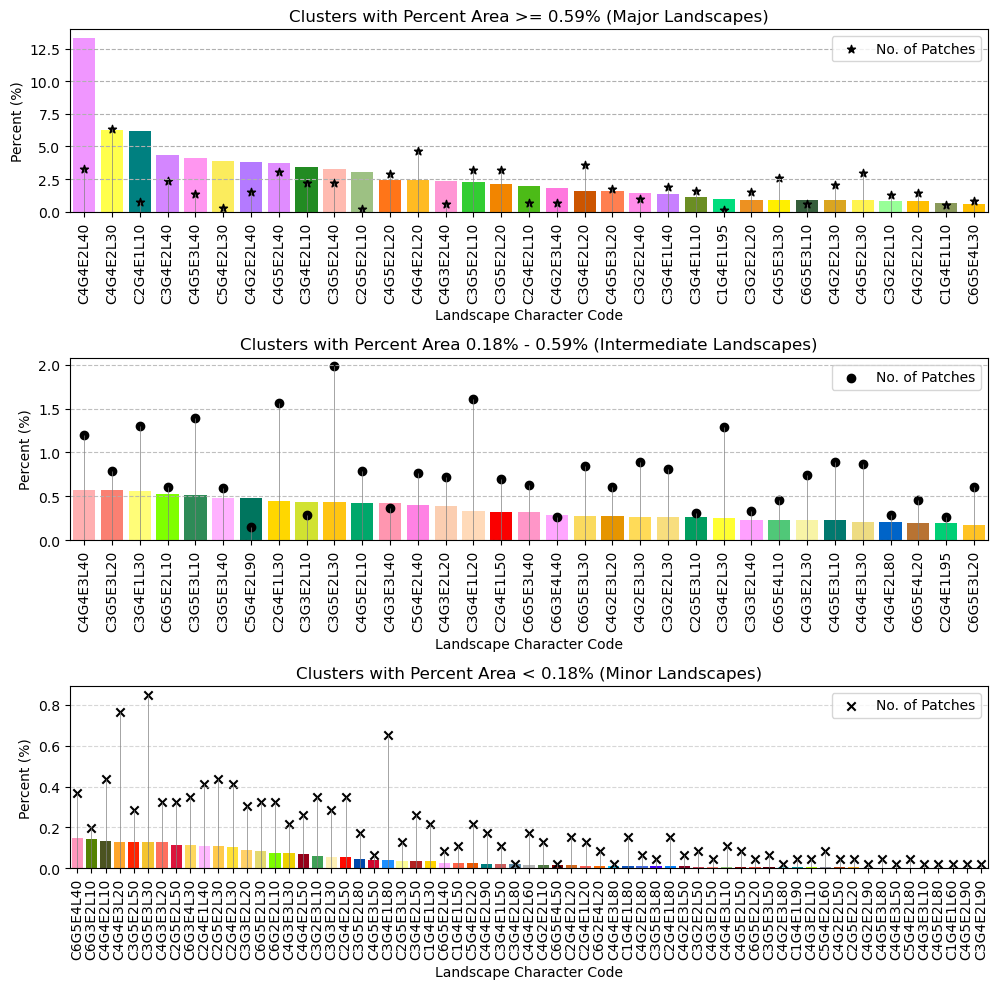

In [88]:
# Sum the areas by complete_code to get the total area for each landscape character
clusters_area = gdf_joined.groupby('complete_code')['area_sqkm'].sum()

# Calculate the total area of all polygons
total_area = clusters_area.sum()

# Calculate the percentage of the total area for each cluster
percentage_area = (clusters_area / total_area) * 100

# Create a DataFrame to store the cluster statistics
cluster_area_freq = pd.DataFrame({
    'Cluster': clusters_area.index,
    'Total Area': clusters_area.values,
    'Percent Area': percentage_area.values,
    'Color': gdf_joined.groupby('complete_code')['color'].first()  # Get the color for each cluster
})

# Calculate the number of polygons for each cluster
clusters = gdf_joined['complete_code'].value_counts().sort_index()
percentage_clusters = (clusters / clusters.sum()) * 100

# Merge the area and cluster frequency dataframes
cluster_freq_combined = pd.merge(cluster_area_freq,
                                 pd.DataFrame({'Cluster': clusters.index, 'Percent Clusters': percentage_clusters.values}),
                                 on='Cluster')

# Sort the DataFrame by Percent Area in descending order
cluster_freq_combined = cluster_freq_combined.sort_values(by='Percent Area', ascending=False)

# Save the Dataframe to csv
cluster_freq_combined.to_csv('all_output/cluster_freq_stats.csv', index=True)

print(cluster_freq_combined.head(5))

# Calculate quartiles (Q1, Q2 (Median), Q3)
Q1 = cluster_freq_combined['Percent Area'].quantile(0.25)
Q2 = cluster_freq_combined['Percent Area'].quantile(0.50)
Q3 = cluster_freq_combined['Percent Area'].quantile(0.75)

# Filter clusters into different quartile ranges
major_landscape = cluster_freq_combined[cluster_freq_combined['Percent Area'] >= Q3]
intermediate_landscape = cluster_freq_combined[(cluster_freq_combined['Percent Area'] >= Q2) & (cluster_freq_combined['Percent Area'] < Q3)]
minor_landscape = cluster_freq_combined[cluster_freq_combined['Percent Area'] < Q2]

# Create vertically stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Function to draw connecting lines
def add_connecting_lines(ax, data):
    for i in range(len(data['Cluster'])):
        ax.vlines(x=i, ymin=0, ymax=data['Percent Clusters'].iloc[i], colors='grey', linewidth=0.5)

# Plot for major landscapes (>= Q3)
axes[0].bar(major_landscape['Cluster'], major_landscape['Percent Area'], color=major_landscape['Color'])
add_connecting_lines(axes[0], major_landscape)  # Add connecting lines
axes[0].scatter(major_landscape['Cluster'], major_landscape['Percent Clusters'], color='black', marker='*', label='No. of Patches')
axes[0].set_title(f'Clusters with Percent Area >= {Q3:.2f}% (Major Landscapes)')
axes[0].set_xlabel('Landscape Character Code')
axes[0].set_ylabel('Percent (%)')
axes[0].legend()
axes[0].grid(visible=True, which='both', axis='y', linestyle='--', alpha=1)
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlim(-0.5, len(major_landscape) - 0.5)  # Adjust x-axis limits

# Plot for intermediate landscapes (Q2 <= Percent Area < Q3)
axes[1].bar(intermediate_landscape['Cluster'], intermediate_landscape['Percent Area'], color=intermediate_landscape['Color'])
add_connecting_lines(axes[1], intermediate_landscape)  # Add connecting lines
axes[1].scatter(intermediate_landscape['Cluster'], intermediate_landscape['Percent Clusters'], color='black', marker='o', label='No. of Patches')
axes[1].set_title(f'Clusters with Percent Area {Q2:.2f}% - {Q3:.2f}% (Intermediate Landscapes)')
axes[1].set_xlabel('Landscape Character Code')
axes[1].set_ylabel('Percent (%)')
axes[1].legend()
axes[1].grid(visible=True, which='both', axis='y', linestyle='--', alpha=0.8)
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlim(-0.5, len(intermediate_landscape) - 0.5)  # Adjust x-axis limits

# Plot for minor landscapes (< Q2)
axes[2].bar(minor_landscape['Cluster'], minor_landscape['Percent Area'], color=minor_landscape['Color'])
add_connecting_lines(axes[2], minor_landscape)  # Add connecting lines
axes[2].scatter(minor_landscape['Cluster'], minor_landscape['Percent Clusters'], color='black', marker='x', label='No. of Patches')
axes[2].set_title(f'Clusters with Percent Area < {Q2:.2f}% (Minor Landscapes)')
axes[2].set_xlabel('Landscape Character Code')
axes[2].set_ylabel('Percent (%)')
axes[2].legend()
axes[2].grid(visible=True, which='both', axis='y', linestyle='--', alpha=0.5)
axes[2].tick_params(axis='x', rotation=90)
axes[2].set_xlim(-0.5, len(minor_landscape) - 0.5)  # Adjust x-axis limits

# Tight layout for better spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig('all_output/cluster_freq_stats.png')
plt.savefig('all_output/cluster_freq_stats.svg')

# Show the plot
plt.show()

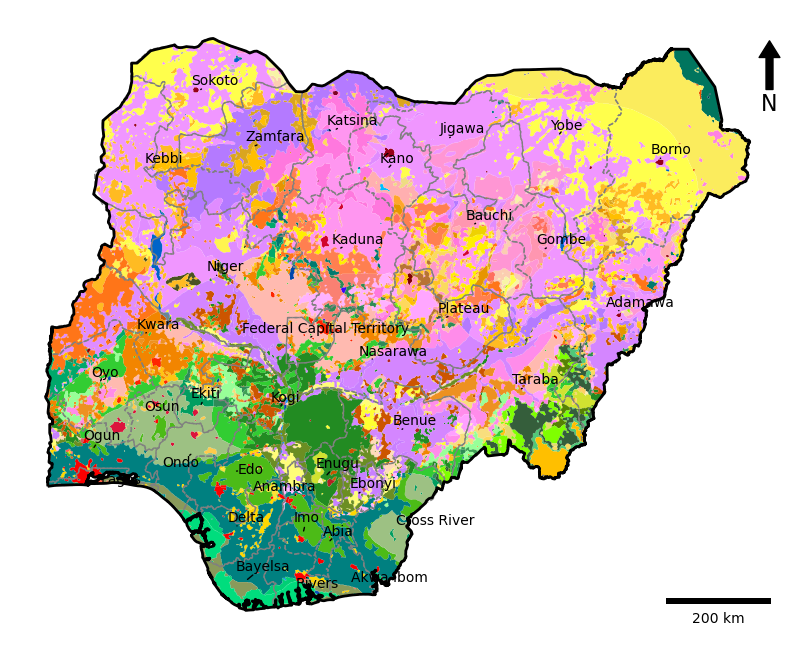

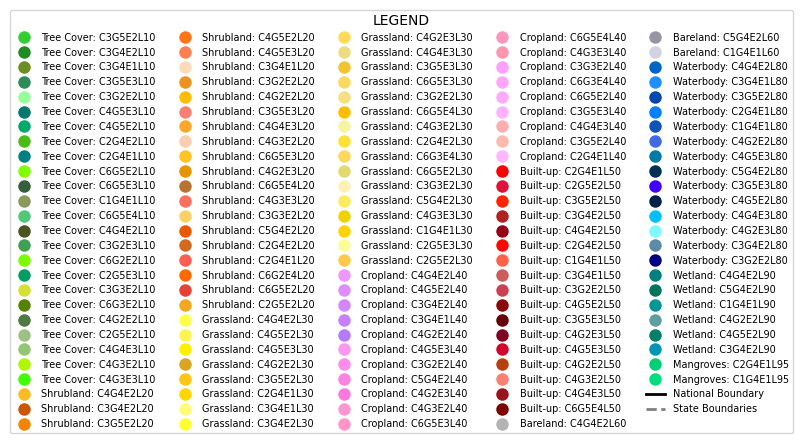

In [89]:
#Overlay state boudary on the landscape character
# Calculate centroids of each state polygon to place text labels
nigeria_states['centroid'] = nigeria_states.geometry.centroid

# Overlay plot of Nigeria state boundaries on the landscape character identified.
fig, ax = plt.subplots(figsize=(10, 10))
gdf_joined.plot(ax=ax, color=gdf_joined['color'], edgecolor=None)  # Plot the main data without outlines

# Adding a basemap (requires gdf_joined to be in EPSG:3857, which it is)
#ctx.add_basemap(ax, crs=gdf_joined.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Overlay state boundaries as hollow (transparent fill) boundaries
nigeria_states.boundary.plot(ax=ax, edgecolor='grey', linewidth=1, linestyle='--', label='State Boundaries')

# Overlay Nigeria boundary as a hollow (transparent fill) boundary layer
nigeria_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=2, linestyle='-', label='Nigeria Boundary')

# Overlay state capitals as points
#gdf_state_capitals.plot(ax=ax, color='black', markersize=10, label='State Capitals')

# Add state capital names and adjust positions
#texts = []
#for x, y, label in zip(gdf_state_capitals.geometry.x, gdf_state_capitals.geometry.y, gdf_state_capitals['Name']):
    #texts.append(ax.text(x, y, label, fontsize=6, ha='right', color='black'))
#adjust_text(texts, ax=ax, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="-", color='black'))

# Add state names at the centroid of each state and use adjust_text to avoid overlap
texts = []
for x, y, label in zip(nigeria_states['centroid'].x, nigeria_states['centroid'].y, nigeria_states['admin1Name']):
    texts.append(ax.text(x, y, label, fontsize=10, ha='center', color='black'))

# Adjust text positions to prevent overlap
adjust_text(texts, ax=ax, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="-", color='black'))

# Add North Arrow (moved to top right)
x, y, arrow_length = 0.98, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=16, xycoords=ax.transAxes)

# Add Scale Bar (ensure correct units)
scalebar = ScaleBar(dx=1, units='m', location='lower right', pad=0.5, border_pad=0.5, sep=5, length_fraction=0.25)
ax.add_artist(scalebar)

# Remove axis for cleaner presentation
ax.axis('off')

# Save the map without the legend
output_dir = 'all_output'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, '2nd_level_lc_admin_without_legend_v2.png'), bbox_inches='tight')
plt.savefig(os.path.join(output_dir, '2nd_level_lc_admin_without_legend_v2.svg'), bbox_inches='tight')

# Create a separate figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(7, 3))  # Adjust the figsize for legend height
legend_elements = []

# Add landscape character codes to the legend
for category, codes in color_dict.items():
    for code, color in codes.items():
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f"{category}: {code}",
                                      markerfacecolor=color, markersize=10))

# Add entries for the new layers
legend_elements.append(Line2D([0], [0], color='black', lw=2, label='National Boundary'))
legend_elements.append(Line2D([0], [0], color='grey', lw=2, linestyle='--', label='State Boundaries'))  # State boundaries
#legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label='State Capitals'))

# Add the legend to a separate figure
ax_legend.legend(handles=legend_elements, title="LEGEND", loc='center', ncol=5, fontsize='7')
ax_legend.axis('off')  # Turn off the axis for the legend figure

# Save the legend as a separate image
plt.savefig(os.path.join(output_dir, '2nd_level_lc_admin_legend_v2.png'), bbox_inches='tight')
plt.savefig(os.path.join(output_dir, '2nd_level_lc_admin_legend_v2.svg'), bbox_inches='tight')

# Display the map and legend separately
plt.show()


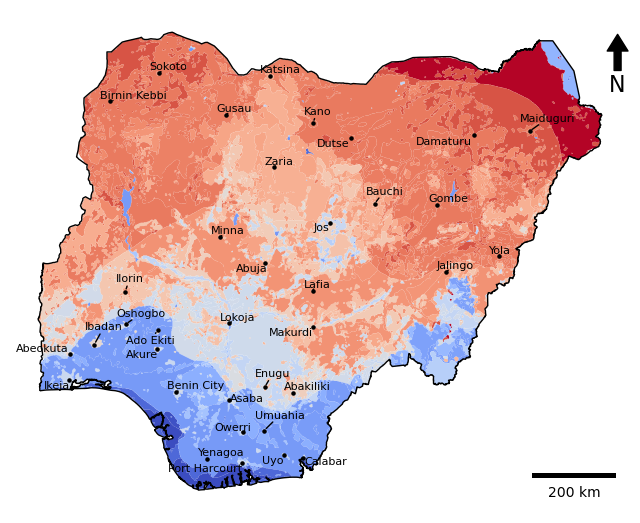

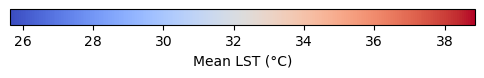

In [90]:
# Plot the GeoDataFrame with Basemap
fig, ax = plt.subplots(figsize=(8, 8))
norm = Normalize(vmin=gdf_joined['mLST'].min(), vmax=gdf_joined['mLST'].max())
cmap = plt.cm.coolwarm  # Use the 'viridis' colormap for a smooth gradient

# Plot the data using the normalized LST values
gdf_joined.plot(column='mLST', ax=ax, cmap=cmap, edgecolor=None, linewidth=1, norm=norm)

# Adding a basemap (requires gdf_joined to be in EPSG:3857)
#ctx.add_basemap(ax, crs=gdf_joined.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Overlay Nigeria boundary as a hollow (transparent fill) boundary layer
nigeria_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='-', label='Nigeria Boundary')

# Overlay state capitals as points
gdf_state_capitals.plot(ax=ax, color='black', markersize=5, label='State Capitals')

# Add state capital names and adjust positions
texts = []
for x, y, label in zip(gdf_state_capitals.geometry.x, gdf_state_capitals.geometry.y, gdf_state_capitals['Name']):
    texts.append(ax.text(x, y, label, fontsize=8, ha='right', color='black'))
adjust_text(texts, ax=ax, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="-", color='black'))

# Add North Arrow
x, y, arrow_length = 0.98, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=16, xycoords=ax.transAxes)

# Add Scale Bar
scalebar = ScaleBar(dx=1, units='m', location='lower right', pad=0.5, border_pad=0.5, sep=5, length_fraction=0.25)
ax.add_artist(scalebar)

# Remove axis for cleaner presentation
ax.axis('off')

# Save the map without the legend if desired
plt.savefig('all_output/LST_LC_without_legend.png', bbox_inches='tight')
plt.savefig('all_output/LST_LC_without_legend.svg', bbox_inches='tight')

# Create a color bar as a legend
fig_colorbar, ax_colorbar = plt.subplots(figsize=(6, 0.2))
cb = ColorbarBase(ax_colorbar, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label('Mean LST (°C)')

# Save the color bar as a separate image
plt.savefig('all_output/LST_LC_colorbar.png', bbox_inches='tight')
plt.savefig('all_output/LST_LC_colorbar.svg', bbox_inches='tight')

# Display the map and color bar separately
plt.show()
